# Real-world data experiment

In [1]:
import numpy as np
import pandas as pd
import joblib
import datetime
import itertools
from tqdm import tqdm

import matplotlib.pyplot as plt

In [2]:
np.random.seed(0)

In [3]:
def highlight_cell(x,y, ax=None, **kwargs):
    rect = plt.Rectangle((x-.5, y-.5), 1,1, fill=False, **kwargs)
    ax = ax or plt.gca()
    ax.add_patch(rect)
    ax.xaxis.set_label_position('top')
    return rect

# Loading data

In [4]:
n_averaging_locations = 2
n_bins = 5

In [5]:
df_LRCS = joblib.load('data/batteries/dfs/df_LRCS_bins_'+str(n_bins)+'.pkl')
df_WMG = joblib.load('data/batteries/dfs/df_WMG_bins_'+str(n_bins)+'_avg_'+str(n_averaging_locations)+'.pkl')
M_LRCS = joblib.load('data/batteries/scms/M_LRCS_bins_'+str(n_bins)+'.pkl')
M_WMG = joblib.load('data/batteries/scms/M_WMG_bins_'+str(n_bins)+'_avg_'+str(n_averaging_locations)+'.pkl')

In [6]:
n_CG_LRCS = len(df_LRCS['Comma gap (µm)'].unique())
n_ML_LRCS = n_bins
dom_CG_LRCS = [75,100,200]
dom_ML_LRCS = np.arange(n_ML_LRCS)

n_CG_WMG = len(df_WMG['CG'].unique())
n_ML_WMG = n_ML_LRCS
dom_CG_WMG = [75,110,150,170,180,200]
dom_ML_WMG = dom_ML_LRCS

ML_WMG_pltlabel = tuple([dom_ML_WMG]*n_averaging_locations)
ML_WMG_pltlabels = list(itertools.product(*ML_WMG_pltlabel))

In [7]:
len(df_LRCS)

64

In [8]:
len(df_WMG)

239

# Setting up an abstraction

In [9]:
R = ['CG']
a = {'CG': 'CG'}

for n in range(n_averaging_locations):
    R.append('ML'+str(n))
    a['ML'+str(n)] = 'ML'

In [10]:
from src.SCMMappings_1_1 import Abstraction

In [11]:
A = Abstraction(M_WMG,M_LRCS,R,a)

In [12]:
import src.evaluationsets as es
import src.learning as lng

In [13]:
J = es.get_causal_sets_in_M1_with_directed_path_in_M1_and_M0(M_WMG,M_LRCS,a)
print(J)

[[['CG'], ['ML']]]


This enumeration is not feasible.

# Learning an abstraction 

In [14]:
import torch
from src.nn import JointNeuralNet
from src.nn_losses import JSD_loss,RowMax_penalty

In [15]:
def train_a_JointNN_model(M0,M1,R,a,J,Ws,T,lmbda,num_epochs,lr):
    model = JointNeuralNet(M0,M1,R,a,J,T)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion_jsd = JSD_loss()
    criterion_pen = RowMax_penalty()
    
    for epoch in range(num_epochs):
        lowpaths, highpaths, Ws = model()    
        loss_jsd = criterion_jsd(lowpaths, highpaths)
        loss_pen = criterion_pen(Ws)
        loss = lmbda*loss_jsd + loss_pen

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (epoch+1) % (num_epochs/20) == 0:
            print ('Epoch [{}/{}], Loss: {:.4f}, JSD: {:.4f}, Penalty: {:.4f}'.format(epoch+1, num_epochs, loss, loss_jsd, loss_pen))
    
    lowpaths, highpaths, Ws = model()    
    loss_jsd = criterion_jsd(lowpaths, highpaths)
    return model,loss_jsd,loss_pen

In [16]:
lrs = [0.001,0.002,0.005]
nums_epochs = [10**4]
Ts = [0.1,0.2]
lmbdas = [5.0,10.0]

n_ensemble = 50

In [17]:
nns=[]
loss_jsd = []
loss_pen = []
configs = []

for lr in lrs:
    for num_epochs in nums_epochs:
        for T in Ts:
            for lmbda in lmbdas:

                for n in range(n_ensemble):
                    print('({0}) - lr: {1}, n_e: {2}, T: {3}, lmbda: {4}'.format(n,lr,num_epochs,T,lmbda))
                    nn,jsd,pen = train_a_JointNN_model(A.M0, A.M1, A.R, A.a, J,
                                         Ws=None, T=T, lmbda=lmbda, num_epochs=num_epochs, lr=lr)
                    nns.append(nn)
                    loss_jsd.append(jsd.detach())
                    loss_pen.append(pen.detach())
                    configs.append({'lr': lr, 'n_e': num_epochs, 'T': T, 'lmbda': lmbda})

(0) - lr: 0.001, n_e: 10000, T: 0.1, lmbda: 5.0
Epoch [500/10000], Loss: 3.2905, JSD: 0.6572, Penalty: 0.0046
Epoch [1000/10000], Loss: 1.9648, JSD: 0.2316, Penalty: 0.8069
Epoch [1500/10000], Loss: 1.0478, JSD: 0.0077, Penalty: 1.0091
Epoch [2000/10000], Loss: 1.0091, JSD: 0.0009, Penalty: 1.0047
Epoch [2500/10000], Loss: 1.0087, JSD: 0.0011, Penalty: 1.0030
Epoch [3000/10000], Loss: 1.0059, JSD: 0.0008, Penalty: 1.0021
Epoch [3500/10000], Loss: 1.0071, JSD: 0.0011, Penalty: 1.0015
Epoch [4000/10000], Loss: 1.0043, JSD: 0.0006, Penalty: 1.0011
Epoch [4500/10000], Loss: 1.0078, JSD: 0.0014, Penalty: 1.0008
Epoch [5000/10000], Loss: 1.0052, JSD: 0.0009, Penalty: 1.0006
Epoch [5500/10000], Loss: 1.0057, JSD: 0.0010, Penalty: 1.0005
Epoch [6000/10000], Loss: 1.0039, JSD: 0.0007, Penalty: 1.0004
Epoch [6500/10000], Loss: 1.0041, JSD: 0.0007, Penalty: 1.0003
Epoch [7000/10000], Loss: 1.0054, JSD: 0.0010, Penalty: 1.0002
Epoch [7500/10000], Loss: 1.0033, JSD: 0.0006, Penalty: 1.0002
Epoch [8

Epoch [3000/10000], Loss: 0.4058, JSD: 0.0800, Penalty: 0.0058
Epoch [3500/10000], Loss: 0.4035, JSD: 0.0799, Penalty: 0.0040
Epoch [4000/10000], Loss: 0.4002, JSD: 0.0795, Penalty: 0.0029
Epoch [4500/10000], Loss: 0.3991, JSD: 0.0794, Penalty: 0.0021
Epoch [5000/10000], Loss: 0.3977, JSD: 0.0792, Penalty: 0.0016
Epoch [5500/10000], Loss: 0.3968, JSD: 0.0791, Penalty: 0.0012
Epoch [6000/10000], Loss: 0.3964, JSD: 0.0791, Penalty: 0.0009
Epoch [6500/10000], Loss: 0.3960, JSD: 0.0791, Penalty: 0.0007
Epoch [7000/10000], Loss: 0.3970, JSD: 0.0793, Penalty: 0.0005
Epoch [7500/10000], Loss: 0.3961, JSD: 0.0791, Penalty: 0.0004
Epoch [8000/10000], Loss: 0.3963, JSD: 0.0792, Penalty: 0.0003
Epoch [8500/10000], Loss: 0.3956, JSD: 0.0791, Penalty: 0.0002
Epoch [9000/10000], Loss: 0.3962, JSD: 0.0792, Penalty: 0.0002
Epoch [9500/10000], Loss: 0.3956, JSD: 0.0791, Penalty: 0.0001
Epoch [10000/10000], Loss: 0.3955, JSD: 0.0791, Penalty: 0.0001
(7) - lr: 0.001, n_e: 10000, T: 0.1, lmbda: 5.0
Epoch 

Epoch [6500/10000], Loss: 0.1793, JSD: 0.0220, Penalty: 0.0694
Epoch [7000/10000], Loss: 0.1782, JSD: 0.0213, Penalty: 0.0715
Epoch [7500/10000], Loss: 0.1774, JSD: 0.0207, Penalty: 0.0737
Epoch [8000/10000], Loss: 0.1771, JSD: 0.0208, Penalty: 0.0733
Epoch [8500/10000], Loss: 0.1781, JSD: 0.0217, Penalty: 0.0698
Epoch [9000/10000], Loss: 0.1777, JSD: 0.0213, Penalty: 0.0711
Epoch [9500/10000], Loss: 0.1783, JSD: 0.0215, Penalty: 0.0706
Epoch [10000/10000], Loss: 0.1777, JSD: 0.0214, Penalty: 0.0708
(13) - lr: 0.001, n_e: 10000, T: 0.1, lmbda: 5.0
Epoch [500/10000], Loss: 2.9756, JSD: 0.5928, Penalty: 0.0114
Epoch [1000/10000], Loss: 2.0234, JSD: 0.2357, Penalty: 0.8451
Epoch [1500/10000], Loss: 1.1727, JSD: 0.0592, Penalty: 0.8769
Epoch [2000/10000], Loss: 0.9654, JSD: 0.0161, Penalty: 0.8847
Epoch [2500/10000], Loss: 0.9425, JSD: 0.0088, Penalty: 0.8985
Epoch [3000/10000], Loss: 0.9309, JSD: 0.0057, Penalty: 0.9026
Epoch [3500/10000], Loss: 0.9265, JSD: 0.0042, Penalty: 0.9055
Epoch 

Epoch [10000/10000], Loss: 0.6179, JSD: 0.1228, Penalty: 0.0040
(19) - lr: 0.001, n_e: 10000, T: 0.1, lmbda: 5.0
Epoch [500/10000], Loss: 2.1015, JSD: 0.4070, Penalty: 0.0665
Epoch [1000/10000], Loss: 1.4954, JSD: 0.2768, Penalty: 0.1115
Epoch [1500/10000], Loss: 0.8144, JSD: 0.1545, Penalty: 0.0421
Epoch [2000/10000], Loss: 0.6553, JSD: 0.1292, Penalty: 0.0093
Epoch [2500/10000], Loss: 0.6290, JSD: 0.1251, Penalty: 0.0035
Epoch [3000/10000], Loss: 0.6126, JSD: 0.1221, Penalty: 0.0019
Epoch [3500/10000], Loss: 0.6063, JSD: 0.1210, Penalty: 0.0013
Epoch [4000/10000], Loss: 0.6029, JSD: 0.1204, Penalty: 0.0009
Epoch [4500/10000], Loss: 0.6030, JSD: 0.1205, Penalty: 0.0007
Epoch [5000/10000], Loss: 0.6016, JSD: 0.1202, Penalty: 0.0005
Epoch [5500/10000], Loss: 0.6023, JSD: 0.1204, Penalty: 0.0004
Epoch [6000/10000], Loss: 0.6024, JSD: 0.1204, Penalty: 0.0003
Epoch [6500/10000], Loss: 0.6019, JSD: 0.1203, Penalty: 0.0002
Epoch [7000/10000], Loss: 0.6021, JSD: 0.1204, Penalty: 0.0002
Epoch 

Epoch [2500/10000], Loss: 1.4302, JSD: 0.0921, Penalty: 0.9695
Epoch [3000/10000], Loss: 1.3796, JSD: 0.0767, Penalty: 0.9960
Epoch [3500/10000], Loss: 1.3736, JSD: 0.0751, Penalty: 0.9982
Epoch [4000/10000], Loss: 1.3713, JSD: 0.0745, Penalty: 0.9990
Epoch [4500/10000], Loss: 1.3701, JSD: 0.0742, Penalty: 0.9994
Epoch [5000/10000], Loss: 1.3695, JSD: 0.0740, Penalty: 0.9996
Epoch [5500/10000], Loss: 1.3690, JSD: 0.0739, Penalty: 0.9997
Epoch [6000/10000], Loss: 1.3687, JSD: 0.0738, Penalty: 0.9998
Epoch [6500/10000], Loss: 1.3686, JSD: 0.0737, Penalty: 0.9998
Epoch [7000/10000], Loss: 1.3684, JSD: 0.0737, Penalty: 0.9999
Epoch [7500/10000], Loss: 1.3683, JSD: 0.0737, Penalty: 0.9999
Epoch [8000/10000], Loss: 1.3682, JSD: 0.0737, Penalty: 0.9999
Epoch [8500/10000], Loss: 1.3682, JSD: 0.0736, Penalty: 0.9999
Epoch [9000/10000], Loss: 1.3681, JSD: 0.0736, Penalty: 1.0000
Epoch [9500/10000], Loss: 1.3681, JSD: 0.0736, Penalty: 1.0000
Epoch [10000/10000], Loss: 1.3680, JSD: 0.0736, Penalty

Epoch [5500/10000], Loss: 0.9378, JSD: 0.0025, Penalty: 0.9251
Epoch [6000/10000], Loss: 0.9380, JSD: 0.0020, Penalty: 0.9278
Epoch [6500/10000], Loss: 0.9369, JSD: 0.0022, Penalty: 0.9260
Epoch [7000/10000], Loss: 0.9368, JSD: 0.0022, Penalty: 0.9256
Epoch [7500/10000], Loss: 0.9416, JSD: 0.0031, Penalty: 0.9263
Epoch [8000/10000], Loss: 0.9374, JSD: 0.0016, Penalty: 0.9294
Epoch [8500/10000], Loss: 0.9368, JSD: 0.0020, Penalty: 0.9270
Epoch [9000/10000], Loss: 0.9344, JSD: 0.0013, Penalty: 0.9277
Epoch [9500/10000], Loss: 0.9372, JSD: 0.0020, Penalty: 0.9270
Epoch [10000/10000], Loss: 0.9357, JSD: 0.0017, Penalty: 0.9272
(32) - lr: 0.001, n_e: 10000, T: 0.1, lmbda: 5.0
Epoch [500/10000], Loss: 2.6705, JSD: 0.5239, Penalty: 0.0509
Epoch [1000/10000], Loss: 1.2811, JSD: 0.2303, Penalty: 0.1296
Epoch [1500/10000], Loss: 1.1549, JSD: 0.1966, Penalty: 0.1719
Epoch [2000/10000], Loss: 1.1496, JSD: 0.1955, Penalty: 0.1721
Epoch [2500/10000], Loss: 1.1476, JSD: 0.1950, Penalty: 0.1725
Epoch 

Epoch [8500/10000], Loss: 0.2433, JSD: 0.0437, Penalty: 0.0246
Epoch [9000/10000], Loss: 0.2435, JSD: 0.0438, Penalty: 0.0245
Epoch [9500/10000], Loss: 0.2429, JSD: 0.0437, Penalty: 0.0246
Epoch [10000/10000], Loss: 0.2431, JSD: 0.0438, Penalty: 0.0244
(38) - lr: 0.001, n_e: 10000, T: 0.1, lmbda: 5.0
Epoch [500/10000], Loss: 3.2371, JSD: 0.6416, Penalty: 0.0288
Epoch [1000/10000], Loss: 2.8686, JSD: 0.5614, Penalty: 0.0614
Epoch [1500/10000], Loss: 0.1581, JSD: 0.0252, Penalty: 0.0320
Epoch [2000/10000], Loss: 0.0654, JSD: 0.0092, Penalty: 0.0196
Epoch [2500/10000], Loss: 0.0359, JSD: 0.0049, Penalty: 0.0112
Epoch [3000/10000], Loss: 0.0208, JSD: 0.0026, Penalty: 0.0078
Epoch [3500/10000], Loss: 0.0103, JSD: 0.0009, Penalty: 0.0060
Epoch [4000/10000], Loss: 0.0090, JSD: 0.0009, Penalty: 0.0046
Epoch [4500/10000], Loss: 0.0081, JSD: 0.0009, Penalty: 0.0036
Epoch [5000/10000], Loss: 0.0070, JSD: 0.0008, Penalty: 0.0028
Epoch [5500/10000], Loss: 0.0056, JSD: 0.0007, Penalty: 0.0023
Epoch 

Epoch [1500/10000], Loss: 1.5709, JSD: 0.2977, Penalty: 0.0824
Epoch [2000/10000], Loss: 1.5696, JSD: 0.2974, Penalty: 0.0826
Epoch [2500/10000], Loss: 1.5692, JSD: 0.2975, Penalty: 0.0817
Epoch [3000/10000], Loss: 1.5685, JSD: 0.2973, Penalty: 0.0820
Epoch [3500/10000], Loss: 1.5683, JSD: 0.2973, Penalty: 0.0818
Epoch [4000/10000], Loss: 1.5683, JSD: 0.2973, Penalty: 0.0816
Epoch [4500/10000], Loss: 1.5685, JSD: 0.2973, Penalty: 0.0822
Epoch [5000/10000], Loss: 1.5684, JSD: 0.2976, Penalty: 0.0806
Epoch [5500/10000], Loss: 1.4467, JSD: 0.2886, Penalty: 0.0039
Epoch [6000/10000], Loss: 1.3152, JSD: 0.2622, Penalty: 0.0040
Epoch [6500/10000], Loss: 1.3151, JSD: 0.2619, Penalty: 0.0058
Epoch [7000/10000], Loss: 1.3130, JSD: 0.2614, Penalty: 0.0058
Epoch [7500/10000], Loss: 1.3133, JSD: 0.2615, Penalty: 0.0058
Epoch [8000/10000], Loss: 1.3137, JSD: 0.2616, Penalty: 0.0056
Epoch [8500/10000], Loss: 1.3127, JSD: 0.2614, Penalty: 0.0055
Epoch [9000/10000], Loss: 1.3127, JSD: 0.2615, Penalty:

Epoch [5000/10000], Loss: 0.0146, JSD: 0.0010, Penalty: 0.0046
Epoch [5500/10000], Loss: 0.0133, JSD: 0.0010, Penalty: 0.0036
Epoch [6000/10000], Loss: 0.0084, JSD: 0.0005, Penalty: 0.0029
Epoch [6500/10000], Loss: 0.0089, JSD: 0.0007, Penalty: 0.0023
Epoch [7000/10000], Loss: 0.0100, JSD: 0.0008, Penalty: 0.0019
Epoch [7500/10000], Loss: 0.0080, JSD: 0.0006, Penalty: 0.0015
Epoch [8000/10000], Loss: 0.0111, JSD: 0.0010, Penalty: 0.0012
Epoch [8500/10000], Loss: 0.0127, JSD: 0.0012, Penalty: 0.0010
Epoch [9000/10000], Loss: 0.0068, JSD: 0.0006, Penalty: 0.0008
Epoch [9500/10000], Loss: 0.0149, JSD: 0.0014, Penalty: 0.0007
Epoch [10000/10000], Loss: 0.0125, JSD: 0.0012, Penalty: 0.0006
(1) - lr: 0.001, n_e: 10000, T: 0.1, lmbda: 10.0
Epoch [500/10000], Loss: 4.4991, JSD: 0.3962, Penalty: 0.5366
Epoch [1000/10000], Loss: 2.7543, JSD: 0.1915, Penalty: 0.8393
Epoch [1500/10000], Loss: 2.5325, JSD: 0.1885, Penalty: 0.6473
Epoch [2000/10000], Loss: 1.9741, JSD: 0.1885, Penalty: 0.0890
Epoch 

Epoch [8000/10000], Loss: 1.2022, JSD: 0.1202, Penalty: 0.0003
Epoch [8500/10000], Loss: 1.2021, JSD: 0.1202, Penalty: 0.0002
Epoch [9000/10000], Loss: 1.2020, JSD: 0.1202, Penalty: 0.0002
Epoch [9500/10000], Loss: 1.2019, JSD: 0.1202, Penalty: 0.0001
Epoch [10000/10000], Loss: 1.2019, JSD: 0.1202, Penalty: 0.0001
(7) - lr: 0.001, n_e: 10000, T: 0.1, lmbda: 10.0
Epoch [500/10000], Loss: 5.9396, JSD: 0.5879, Penalty: 0.0605
Epoch [1000/10000], Loss: 3.5750, JSD: 0.3177, Penalty: 0.3984
Epoch [1500/10000], Loss: 0.3351, JSD: 0.0044, Penalty: 0.2910
Epoch [2000/10000], Loss: 0.1280, JSD: 0.0021, Penalty: 0.1068
Epoch [2500/10000], Loss: 0.0851, JSD: 0.0018, Penalty: 0.0668
Epoch [3000/10000], Loss: 0.0559, JSD: 0.0007, Penalty: 0.0484
Epoch [3500/10000], Loss: 0.0457, JSD: 0.0008, Penalty: 0.0374
Epoch [4000/10000], Loss: 0.0398, JSD: 0.0010, Penalty: 0.0303
Epoch [4500/10000], Loss: 0.0379, JSD: 0.0013, Penalty: 0.0250
Epoch [5000/10000], Loss: 0.0277, JSD: 0.0006, Penalty: 0.0212
Epoch 

Epoch [1000/10000], Loss: 1.0438, JSD: 0.0440, Penalty: 0.6042
Epoch [1500/10000], Loss: 0.3311, JSD: 0.0179, Penalty: 0.1522
Epoch [2000/10000], Loss: 0.2413, JSD: 0.0172, Penalty: 0.0689
Epoch [2500/10000], Loss: 0.2100, JSD: 0.0170, Penalty: 0.0398
Epoch [3000/10000], Loss: 0.1995, JSD: 0.0174, Penalty: 0.0258
Epoch [3500/10000], Loss: 0.1878, JSD: 0.0170, Penalty: 0.0176
Epoch [4000/10000], Loss: 0.1838, JSD: 0.0171, Penalty: 0.0128
Epoch [4500/10000], Loss: 0.1792, JSD: 0.0170, Penalty: 0.0096
Epoch [5000/10000], Loss: 0.1746, JSD: 0.0167, Penalty: 0.0071
Epoch [5500/10000], Loss: 0.1730, JSD: 0.0167, Penalty: 0.0056
Epoch [6000/10000], Loss: 0.1714, JSD: 0.0167, Penalty: 0.0043
Epoch [6500/10000], Loss: 0.1721, JSD: 0.0169, Penalty: 0.0035
Epoch [7000/10000], Loss: 0.1694, JSD: 0.0167, Penalty: 0.0027
Epoch [7500/10000], Loss: 0.1683, JSD: 0.0166, Penalty: 0.0021
Epoch [8000/10000], Loss: 0.1698, JSD: 0.0168, Penalty: 0.0017
Epoch [8500/10000], Loss: 0.1673, JSD: 0.0166, Penalty:

Epoch [4000/10000], Loss: 0.6148, JSD: 0.0014, Penalty: 0.6006
Epoch [4500/10000], Loss: 0.6092, JSD: 0.0009, Penalty: 0.5999
Epoch [5000/10000], Loss: 0.6118, JSD: 0.0013, Penalty: 0.5991
Epoch [5500/10000], Loss: 0.6092, JSD: 0.0012, Penalty: 0.5974
Epoch [6000/10000], Loss: 0.6114, JSD: 0.0016, Penalty: 0.5954
Epoch [6500/10000], Loss: 0.6042, JSD: 0.0008, Penalty: 0.5957
Epoch [7000/10000], Loss: 0.6060, JSD: 0.0010, Penalty: 0.5961
Epoch [7500/10000], Loss: 0.6035, JSD: 0.0009, Penalty: 0.5948
Epoch [8000/10000], Loss: 0.6110, JSD: 0.0019, Penalty: 0.5917
Epoch [8500/10000], Loss: 0.5982, JSD: 0.0007, Penalty: 0.5915
Epoch [9000/10000], Loss: 0.6100, JSD: 0.0022, Penalty: 0.5881
Epoch [9500/10000], Loss: 0.5964, JSD: 0.0010, Penalty: 0.5860
Epoch [10000/10000], Loss: 0.5885, JSD: 0.0007, Penalty: 0.5818
(20) - lr: 0.001, n_e: 10000, T: 0.1, lmbda: 10.0
Epoch [500/10000], Loss: 4.6251, JSD: 0.4319, Penalty: 0.3064
Epoch [1000/10000], Loss: 0.4940, JSD: 0.0209, Penalty: 0.2849
Epoch

Epoch [7000/10000], Loss: 0.5166, JSD: 0.0030, Penalty: 0.4870
Epoch [7500/10000], Loss: 0.5170, JSD: 0.0030, Penalty: 0.4874
Epoch [8000/10000], Loss: 0.5155, JSD: 0.0025, Penalty: 0.4904
Epoch [8500/10000], Loss: 0.5361, JSD: 0.0048, Penalty: 0.4877
Epoch [9000/10000], Loss: 0.5148, JSD: 0.0026, Penalty: 0.4886
Epoch [9500/10000], Loss: 0.5135, JSD: 0.0021, Penalty: 0.4924
Epoch [10000/10000], Loss: 0.5143, JSD: 0.0023, Penalty: 0.4915
(26) - lr: 0.001, n_e: 10000, T: 0.1, lmbda: 10.0
Epoch [500/10000], Loss: 6.8103, JSD: 0.6809, Penalty: 0.0010
Epoch [1000/10000], Loss: 0.7955, JSD: 0.0741, Penalty: 0.0546
Epoch [1500/10000], Loss: 0.0560, JSD: 0.0033, Penalty: 0.0226
Epoch [2000/10000], Loss: 0.0191, JSD: 0.0007, Penalty: 0.0120
Epoch [2500/10000], Loss: 0.0167, JSD: 0.0009, Penalty: 0.0078
Epoch [3000/10000], Loss: 0.0135, JSD: 0.0008, Penalty: 0.0053
Epoch [3500/10000], Loss: 0.0136, JSD: 0.0010, Penalty: 0.0038
Epoch [4000/10000], Loss: 0.0096, JSD: 0.0007, Penalty: 0.0028
Epoch

Epoch [10000/10000], Loss: 0.5021, JSD: 0.0007, Penalty: 0.4947
(32) - lr: 0.001, n_e: 10000, T: 0.1, lmbda: 10.0
Epoch [500/10000], Loss: 2.2856, JSD: 0.1794, Penalty: 0.4915
Epoch [1000/10000], Loss: 2.1294, JSD: 0.1612, Penalty: 0.5176
Epoch [1500/10000], Loss: 2.1132, JSD: 0.1598, Penalty: 0.5148
Epoch [2000/10000], Loss: 2.1003, JSD: 0.1596, Penalty: 0.5046
Epoch [2500/10000], Loss: 1.7253, JSD: 0.1629, Penalty: 0.0967
Epoch [3000/10000], Loss: 1.6945, JSD: 0.1622, Penalty: 0.0723
Epoch [3500/10000], Loss: 1.6889, JSD: 0.1620, Penalty: 0.0691
Epoch [4000/10000], Loss: 1.6804, JSD: 0.1621, Penalty: 0.0591
Epoch [4500/10000], Loss: 1.6763, JSD: 0.1617, Penalty: 0.0592
Epoch [5000/10000], Loss: 1.6759, JSD: 0.1615, Penalty: 0.0606
Epoch [5500/10000], Loss: 1.5950, JSD: 0.1573, Penalty: 0.0218
Epoch [6000/10000], Loss: 1.5885, JSD: 0.1534, Penalty: 0.0547
Epoch [6500/10000], Loss: 1.5812, JSD: 0.1491, Penalty: 0.0905
Epoch [7000/10000], Loss: 1.5793, JSD: 0.1481, Penalty: 0.0983
Epoch

Epoch [3000/10000], Loss: 1.0374, JSD: 0.0615, Penalty: 0.4226
Epoch [3500/10000], Loss: 1.0337, JSD: 0.0611, Penalty: 0.4224
Epoch [4000/10000], Loss: 1.0348, JSD: 0.0612, Penalty: 0.4229
Epoch [4500/10000], Loss: 1.0326, JSD: 0.0611, Penalty: 0.4216
Epoch [5000/10000], Loss: 1.0337, JSD: 0.0611, Penalty: 0.4228
Epoch [5500/10000], Loss: 1.0333, JSD: 0.0610, Penalty: 0.4229
Epoch [6000/10000], Loss: 1.0300, JSD: 0.0608, Penalty: 0.4219
Epoch [6500/10000], Loss: 1.0317, JSD: 0.0609, Penalty: 0.4226
Epoch [7000/10000], Loss: 1.0305, JSD: 0.0609, Penalty: 0.4216
Epoch [7500/10000], Loss: 1.0314, JSD: 0.0609, Penalty: 0.4228
Epoch [8000/10000], Loss: 1.0316, JSD: 0.0610, Penalty: 0.4214
Epoch [8500/10000], Loss: 1.0330, JSD: 0.0609, Penalty: 0.4235
Epoch [9000/10000], Loss: 1.0298, JSD: 0.0608, Penalty: 0.4219
Epoch [9500/10000], Loss: 1.0348, JSD: 0.0611, Penalty: 0.4241
Epoch [10000/10000], Loss: 1.0329, JSD: 0.0609, Penalty: 0.4235
(39) - lr: 0.001, n_e: 10000, T: 0.1, lmbda: 10.0
Epoc

Epoch [6000/10000], Loss: 0.1360, JSD: 0.0010, Penalty: 0.1256
Epoch [6500/10000], Loss: 0.1427, JSD: 0.0017, Penalty: 0.1256
Epoch [7000/10000], Loss: 0.1345, JSD: 0.0009, Penalty: 0.1258
Epoch [7500/10000], Loss: 0.1326, JSD: 0.0008, Penalty: 0.1250
Epoch [8000/10000], Loss: 0.1338, JSD: 0.0009, Penalty: 0.1251
Epoch [8500/10000], Loss: 0.1348, JSD: 0.0010, Penalty: 0.1245
Epoch [9000/10000], Loss: 0.1328, JSD: 0.0008, Penalty: 0.1250
Epoch [9500/10000], Loss: 0.1337, JSD: 0.0008, Penalty: 0.1257
Epoch [10000/10000], Loss: 0.1364, JSD: 0.0012, Penalty: 0.1243
(45) - lr: 0.001, n_e: 10000, T: 0.1, lmbda: 10.0
Epoch [500/10000], Loss: 5.5465, JSD: 0.5512, Penalty: 0.0342
Epoch [1000/10000], Loss: 1.4603, JSD: 0.1408, Penalty: 0.0519
Epoch [1500/10000], Loss: 0.1131, JSD: 0.0091, Penalty: 0.0219
Epoch [2000/10000], Loss: 0.0567, JSD: 0.0042, Penalty: 0.0149
Epoch [2500/10000], Loss: 0.0394, JSD: 0.0029, Penalty: 0.0102
Epoch [3000/10000], Loss: 0.0285, JSD: 0.0021, Penalty: 0.0075
Epoch

Epoch [9000/10000], Loss: 0.0065, JSD: 0.0006, Penalty: 0.0036
Epoch [9500/10000], Loss: 0.0065, JSD: 0.0007, Penalty: 0.0029
Epoch [10000/10000], Loss: 0.0055, JSD: 0.0006, Penalty: 0.0025
(1) - lr: 0.001, n_e: 10000, T: 0.2, lmbda: 5.0
Epoch [500/10000], Loss: 3.0020, JSD: 0.5723, Penalty: 0.1406
Epoch [1000/10000], Loss: 2.1490, JSD: 0.3521, Penalty: 0.3886
Epoch [1500/10000], Loss: 1.5294, JSD: 0.2067, Penalty: 0.4961
Epoch [2000/10000], Loss: 0.4048, JSD: 0.0534, Penalty: 0.1378
Epoch [2500/10000], Loss: 0.2359, JSD: 0.0339, Penalty: 0.0663
Epoch [3000/10000], Loss: 0.1444, JSD: 0.0197, Penalty: 0.0460
Epoch [3500/10000], Loss: 0.1256, JSD: 0.0192, Penalty: 0.0297
Epoch [4000/10000], Loss: 0.1143, JSD: 0.0188, Penalty: 0.0202
Epoch [4500/10000], Loss: 0.0279, JSD: 0.0017, Penalty: 0.0192
Epoch [5000/10000], Loss: 0.0180, JSD: 0.0006, Penalty: 0.0150
Epoch [5500/10000], Loss: 0.0146, JSD: 0.0006, Penalty: 0.0117
Epoch [6000/10000], Loss: 0.0120, JSD: 0.0005, Penalty: 0.0093
Epoch [

Epoch [2000/10000], Loss: 0.9292, JSD: 0.0944, Penalty: 0.4573
Epoch [2500/10000], Loss: 0.8084, JSD: 0.0583, Penalty: 0.5168
Epoch [3000/10000], Loss: 0.2960, JSD: 0.0170, Penalty: 0.2108
Epoch [3500/10000], Loss: 0.1393, JSD: 0.0118, Penalty: 0.0803
Epoch [4000/10000], Loss: 0.0915, JSD: 0.0078, Penalty: 0.0524
Epoch [4500/10000], Loss: 0.0640, JSD: 0.0046, Penalty: 0.0412
Epoch [5000/10000], Loss: 0.0535, JSD: 0.0042, Penalty: 0.0322
Epoch [5500/10000], Loss: 0.0466, JSD: 0.0039, Penalty: 0.0273
Epoch [6000/10000], Loss: 0.0391, JSD: 0.0030, Penalty: 0.0242
Epoch [6500/10000], Loss: 0.0262, JSD: 0.0007, Penalty: 0.0228
Epoch [7000/10000], Loss: 0.0247, JSD: 0.0008, Penalty: 0.0209
Epoch [7500/10000], Loss: 0.0228, JSD: 0.0006, Penalty: 0.0196
Epoch [8000/10000], Loss: 0.0227, JSD: 0.0008, Penalty: 0.0186
Epoch [8500/10000], Loss: 0.0205, JSD: 0.0006, Penalty: 0.0177
Epoch [9000/10000], Loss: 0.0200, JSD: 0.0006, Penalty: 0.0171
Epoch [9500/10000], Loss: 0.0195, JSD: 0.0006, Penalty:

Epoch [5000/10000], Loss: 0.4895, JSD: 0.0009, Penalty: 0.4849
Epoch [5500/10000], Loss: 0.4874, JSD: 0.0009, Penalty: 0.4828
Epoch [6000/10000], Loss: 0.4858, JSD: 0.0009, Penalty: 0.4815
Epoch [6500/10000], Loss: 0.4843, JSD: 0.0007, Penalty: 0.4805
Epoch [7000/10000], Loss: 0.4843, JSD: 0.0009, Penalty: 0.4795
Epoch [7500/10000], Loss: 0.4818, JSD: 0.0007, Penalty: 0.4781
Epoch [8000/10000], Loss: 0.4814, JSD: 0.0011, Penalty: 0.4757
Epoch [8500/10000], Loss: 0.4804, JSD: 0.0013, Penalty: 0.4740
Epoch [9000/10000], Loss: 0.4783, JSD: 0.0008, Penalty: 0.4741
Epoch [9500/10000], Loss: 0.4425, JSD: 0.0009, Penalty: 0.4379
Epoch [10000/10000], Loss: 0.2935, JSD: 0.0008, Penalty: 0.2897
(14) - lr: 0.001, n_e: 10000, T: 0.2, lmbda: 5.0
Epoch [500/10000], Loss: 2.6326, JSD: 0.4646, Penalty: 0.3098
Epoch [1000/10000], Loss: 1.7509, JSD: 0.1641, Penalty: 0.9306
Epoch [1500/10000], Loss: 1.6048, JSD: 0.1228, Penalty: 0.9908
Epoch [2000/10000], Loss: 1.5614, JSD: 0.1182, Penalty: 0.9702
Epoch 

Epoch [8000/10000], Loss: 0.9873, JSD: 0.1351, Penalty: 0.3120
Epoch [8500/10000], Loss: 0.9872, JSD: 0.1350, Penalty: 0.3123
Epoch [9000/10000], Loss: 0.9870, JSD: 0.1350, Penalty: 0.3120
Epoch [9500/10000], Loss: 0.9863, JSD: 0.1347, Penalty: 0.3129
Epoch [10000/10000], Loss: 0.9864, JSD: 0.1346, Penalty: 0.3132
(20) - lr: 0.001, n_e: 10000, T: 0.2, lmbda: 5.0
Epoch [500/10000], Loss: 3.4811, JSD: 0.6926, Penalty: 0.0182
Epoch [1000/10000], Loss: 2.5125, JSD: 0.4501, Penalty: 0.2620
Epoch [1500/10000], Loss: 1.5649, JSD: 0.1225, Penalty: 0.9524
Epoch [2000/10000], Loss: 0.9803, JSD: 0.0298, Penalty: 0.8312
Epoch [2500/10000], Loss: 0.7930, JSD: 0.0199, Penalty: 0.6934
Epoch [3000/10000], Loss: 0.7551, JSD: 0.0195, Penalty: 0.6578
Epoch [3500/10000], Loss: 0.6446, JSD: 0.0200, Penalty: 0.5445
Epoch [4000/10000], Loss: 0.6318, JSD: 0.0200, Penalty: 0.5318
Epoch [4500/10000], Loss: 0.6210, JSD: 0.0179, Penalty: 0.5316
Epoch [5000/10000], Loss: 0.6135, JSD: 0.0160, Penalty: 0.5337
Epoch 

Epoch [1000/10000], Loss: 1.8450, JSD: 0.3135, Penalty: 0.2775
Epoch [1500/10000], Loss: 1.3917, JSD: 0.1507, Penalty: 0.6382
Epoch [2000/10000], Loss: 1.2123, JSD: 0.0786, Penalty: 0.8191
Epoch [2500/10000], Loss: 1.1818, JSD: 0.0715, Penalty: 0.8242
Epoch [3000/10000], Loss: 1.1705, JSD: 0.0699, Penalty: 0.8208
Epoch [3500/10000], Loss: 1.1647, JSD: 0.0698, Penalty: 0.8158
Epoch [4000/10000], Loss: 1.1612, JSD: 0.0701, Penalty: 0.8108
Epoch [4500/10000], Loss: 1.1590, JSD: 0.0704, Penalty: 0.8069
Epoch [5000/10000], Loss: 1.1591, JSD: 0.0708, Penalty: 0.8051
Epoch [5500/10000], Loss: 1.1568, JSD: 0.0713, Penalty: 0.8003
Epoch [6000/10000], Loss: 1.1562, JSD: 0.0715, Penalty: 0.7989
Epoch [6500/10000], Loss: 1.1553, JSD: 0.0717, Penalty: 0.7967
Epoch [7000/10000], Loss: 1.1567, JSD: 0.0719, Penalty: 0.7972
Epoch [7500/10000], Loss: 1.1548, JSD: 0.0721, Penalty: 0.7942
Epoch [8000/10000], Loss: 1.1556, JSD: 0.0722, Penalty: 0.7944
Epoch [8500/10000], Loss: 1.1544, JSD: 0.0723, Penalty:

Epoch [4000/10000], Loss: 0.6357, JSD: 0.0041, Penalty: 0.6152
Epoch [4500/10000], Loss: 0.6135, JSD: 0.0012, Penalty: 0.6073
Epoch [5000/10000], Loss: 0.5938, JSD: 0.0008, Penalty: 0.5898
Epoch [5500/10000], Loss: 0.5580, JSD: 0.0008, Penalty: 0.5541
Epoch [6000/10000], Loss: 0.4716, JSD: 0.0009, Penalty: 0.4672
Epoch [6500/10000], Loss: 0.3458, JSD: 0.0008, Penalty: 0.3418
Epoch [7000/10000], Loss: 0.1665, JSD: 0.0007, Penalty: 0.1629
Epoch [7500/10000], Loss: 0.0766, JSD: 0.0005, Penalty: 0.0740
Epoch [8000/10000], Loss: 0.0472, JSD: 0.0007, Penalty: 0.0437
Epoch [8500/10000], Loss: 0.0318, JSD: 0.0005, Penalty: 0.0291
Epoch [9000/10000], Loss: 0.0234, JSD: 0.0005, Penalty: 0.0207
Epoch [9500/10000], Loss: 0.0183, JSD: 0.0006, Penalty: 0.0152
Epoch [10000/10000], Loss: 0.0144, JSD: 0.0006, Penalty: 0.0116
(33) - lr: 0.001, n_e: 10000, T: 0.2, lmbda: 5.0
Epoch [500/10000], Loss: 3.1535, JSD: 0.6219, Penalty: 0.0439
Epoch [1000/10000], Loss: 2.5155, JSD: 0.4992, Penalty: 0.0197
Epoch 

Epoch [7000/10000], Loss: 0.0079, JSD: 0.0006, Penalty: 0.0048
Epoch [7500/10000], Loss: 0.0071, JSD: 0.0007, Penalty: 0.0038
Epoch [8000/10000], Loss: 0.0062, JSD: 0.0006, Penalty: 0.0030
Epoch [8500/10000], Loss: 0.0053, JSD: 0.0006, Penalty: 0.0024
Epoch [9000/10000], Loss: 0.0055, JSD: 0.0007, Penalty: 0.0020
Epoch [9500/10000], Loss: 0.0052, JSD: 0.0007, Penalty: 0.0016
Epoch [10000/10000], Loss: 0.0043, JSD: 0.0006, Penalty: 0.0013
(39) - lr: 0.001, n_e: 10000, T: 0.2, lmbda: 5.0
Epoch [500/10000], Loss: 2.7667, JSD: 0.5031, Penalty: 0.2510
Epoch [1000/10000], Loss: 1.6252, JSD: 0.2371, Penalty: 0.4395
Epoch [1500/10000], Loss: 0.5634, JSD: 0.0637, Penalty: 0.2447
Epoch [2000/10000], Loss: 0.1973, JSD: 0.0177, Penalty: 0.1091
Epoch [2500/10000], Loss: 0.0779, JSD: 0.0016, Penalty: 0.0701
Epoch [3000/10000], Loss: 0.0502, JSD: 0.0007, Penalty: 0.0469
Epoch [3500/10000], Loss: 0.0373, JSD: 0.0006, Penalty: 0.0343
Epoch [4000/10000], Loss: 0.0298, JSD: 0.0008, Penalty: 0.0260
Epoch 

Epoch [10000/10000], Loss: 0.1838, JSD: 0.0006, Penalty: 0.1808
(45) - lr: 0.001, n_e: 10000, T: 0.2, lmbda: 5.0
Epoch [500/10000], Loss: 2.4933, JSD: 0.4831, Penalty: 0.0780
Epoch [1000/10000], Loss: 1.6950, JSD: 0.2725, Penalty: 0.3327
Epoch [1500/10000], Loss: 1.5901, JSD: 0.2417, Penalty: 0.3814
Epoch [2000/10000], Loss: 1.5605, JSD: 0.2348, Penalty: 0.3863
Epoch [2500/10000], Loss: 1.5398, JSD: 0.2292, Penalty: 0.3938
Epoch [3000/10000], Loss: 1.5303, JSD: 0.2273, Penalty: 0.3938
Epoch [3500/10000], Loss: 1.5250, JSD: 0.2263, Penalty: 0.3934
Epoch [4000/10000], Loss: 1.5220, JSD: 0.2257, Penalty: 0.3934
Epoch [4500/10000], Loss: 1.5195, JSD: 0.2255, Penalty: 0.3918
Epoch [5000/10000], Loss: 1.5174, JSD: 0.2251, Penalty: 0.3917
Epoch [5500/10000], Loss: 1.5136, JSD: 0.2239, Penalty: 0.3939
Epoch [6000/10000], Loss: 1.5121, JSD: 0.2237, Penalty: 0.3935
Epoch [6500/10000], Loss: 1.5116, JSD: 0.2236, Penalty: 0.3938
Epoch [7000/10000], Loss: 1.5109, JSD: 0.2235, Penalty: 0.3932
Epoch 

Epoch [3000/10000], Loss: 0.2191, JSD: 0.0006, Penalty: 0.2133
Epoch [3500/10000], Loss: 0.1855, JSD: 0.0006, Penalty: 0.1790
Epoch [4000/10000], Loss: 0.1607, JSD: 0.0006, Penalty: 0.1550
Epoch [4500/10000], Loss: 0.1431, JSD: 0.0006, Penalty: 0.1374
Epoch [5000/10000], Loss: 0.1307, JSD: 0.0007, Penalty: 0.1240
Epoch [5500/10000], Loss: 0.1018, JSD: 0.0006, Penalty: 0.0955
Epoch [6000/10000], Loss: 0.0828, JSD: 0.0007, Penalty: 0.0759
Epoch [6500/10000], Loss: 0.0682, JSD: 0.0006, Penalty: 0.0626
Epoch [7000/10000], Loss: 0.0589, JSD: 0.0006, Penalty: 0.0529
Epoch [7500/10000], Loss: 0.0511, JSD: 0.0006, Penalty: 0.0453
Epoch [8000/10000], Loss: 0.0451, JSD: 0.0005, Penalty: 0.0397
Epoch [8500/10000], Loss: 0.0417, JSD: 0.0006, Penalty: 0.0352
Epoch [9000/10000], Loss: 0.0403, JSD: 0.0009, Penalty: 0.0315
Epoch [9500/10000], Loss: 0.0339, JSD: 0.0005, Penalty: 0.0285
Epoch [10000/10000], Loss: 0.0317, JSD: 0.0006, Penalty: 0.0260
(2) - lr: 0.001, n_e: 10000, T: 0.2, lmbda: 10.0
Epoch

Epoch [6000/10000], Loss: 0.0194, JSD: 0.0005, Penalty: 0.0141
Epoch [6500/10000], Loss: 0.0168, JSD: 0.0005, Penalty: 0.0115
Epoch [7000/10000], Loss: 0.0174, JSD: 0.0008, Penalty: 0.0095
Epoch [7500/10000], Loss: 0.0153, JSD: 0.0007, Penalty: 0.0079
Epoch [8000/10000], Loss: 0.0130, JSD: 0.0007, Penalty: 0.0065
Epoch [8500/10000], Loss: 0.0130, JSD: 0.0008, Penalty: 0.0054
Epoch [9000/10000], Loss: 0.0106, JSD: 0.0006, Penalty: 0.0045
Epoch [9500/10000], Loss: 0.0103, JSD: 0.0006, Penalty: 0.0038
Epoch [10000/10000], Loss: 0.0102, JSD: 0.0007, Penalty: 0.0032
(8) - lr: 0.001, n_e: 10000, T: 0.2, lmbda: 10.0
Epoch [500/10000], Loss: 6.7689, JSD: 0.6737, Penalty: 0.0320
Epoch [1000/10000], Loss: 2.3456, JSD: 0.2054, Penalty: 0.2919
Epoch [1500/10000], Loss: 0.4956, JSD: 0.0290, Penalty: 0.2055
Epoch [2000/10000], Loss: 0.2289, JSD: 0.0117, Penalty: 0.1120
Epoch [2500/10000], Loss: 0.1782, JSD: 0.0112, Penalty: 0.0667
Epoch [3000/10000], Loss: 0.1506, JSD: 0.0106, Penalty: 0.0450
Epoch 

Epoch [9000/10000], Loss: 0.1418, JSD: 0.0007, Penalty: 0.1350
Epoch [9500/10000], Loss: 0.0976, JSD: 0.0006, Penalty: 0.0916
Epoch [10000/10000], Loss: 0.0714, JSD: 0.0006, Penalty: 0.0657
(14) - lr: 0.001, n_e: 10000, T: 0.2, lmbda: 10.0
Epoch [500/10000], Loss: 5.3456, JSD: 0.5282, Penalty: 0.0635
Epoch [1000/10000], Loss: 2.2387, JSD: 0.1556, Penalty: 0.6832
Epoch [1500/10000], Loss: 1.3405, JSD: 0.0344, Penalty: 0.9968
Epoch [2000/10000], Loss: 1.0942, JSD: 0.0020, Penalty: 1.0745
Epoch [2500/10000], Loss: 1.0694, JSD: 0.0010, Penalty: 1.0598
Epoch [3000/10000], Loss: 1.0623, JSD: 0.0014, Penalty: 1.0485
Epoch [3500/10000], Loss: 1.0495, JSD: 0.0008, Penalty: 1.0419
Epoch [4000/10000], Loss: 1.0446, JSD: 0.0008, Penalty: 1.0363
Epoch [4500/10000], Loss: 1.0390, JSD: 0.0008, Penalty: 1.0314
Epoch [5000/10000], Loss: 1.0378, JSD: 0.0010, Penalty: 1.0277
Epoch [5500/10000], Loss: 1.0358, JSD: 0.0014, Penalty: 1.0222
Epoch [6000/10000], Loss: 1.0254, JSD: 0.0007, Penalty: 1.0187
Epoch

Epoch [2000/10000], Loss: 0.4890, JSD: 0.0228, Penalty: 0.2614
Epoch [2500/10000], Loss: 0.1874, JSD: 0.0058, Penalty: 0.1297
Epoch [3000/10000], Loss: 0.1007, JSD: 0.0016, Penalty: 0.0851
Epoch [3500/10000], Loss: 0.0698, JSD: 0.0007, Penalty: 0.0627
Epoch [4000/10000], Loss: 0.0575, JSD: 0.0008, Penalty: 0.0495
Epoch [4500/10000], Loss: 0.0458, JSD: 0.0006, Penalty: 0.0403
Epoch [5000/10000], Loss: 0.0396, JSD: 0.0006, Penalty: 0.0335
Epoch [5500/10000], Loss: 0.0359, JSD: 0.0007, Penalty: 0.0284
Epoch [6000/10000], Loss: 0.0300, JSD: 0.0006, Penalty: 0.0243
Epoch [6500/10000], Loss: 0.0270, JSD: 0.0006, Penalty: 0.0212
Epoch [7000/10000], Loss: 0.0237, JSD: 0.0005, Penalty: 0.0187
Epoch [7500/10000], Loss: 0.0230, JSD: 0.0006, Penalty: 0.0167
Epoch [8000/10000], Loss: 0.0204, JSD: 0.0005, Penalty: 0.0151
Epoch [8500/10000], Loss: 0.0191, JSD: 0.0005, Penalty: 0.0138
Epoch [9000/10000], Loss: 0.0191, JSD: 0.0006, Penalty: 0.0128
Epoch [9500/10000], Loss: 0.0175, JSD: 0.0006, Penalty:

Epoch [5000/10000], Loss: 0.0824, JSD: 0.0064, Penalty: 0.0183
Epoch [5500/10000], Loss: 0.0774, JSD: 0.0063, Penalty: 0.0143
Epoch [6000/10000], Loss: 0.0736, JSD: 0.0062, Penalty: 0.0112
Epoch [6500/10000], Loss: 0.0247, JSD: 0.0014, Penalty: 0.0109
Epoch [7000/10000], Loss: 0.0165, JSD: 0.0008, Penalty: 0.0086
Epoch [7500/10000], Loss: 0.0129, JSD: 0.0006, Penalty: 0.0070
Epoch [8000/10000], Loss: 0.0115, JSD: 0.0006, Penalty: 0.0059
Epoch [8500/10000], Loss: 0.0101, JSD: 0.0005, Penalty: 0.0049
Epoch [9000/10000], Loss: 0.0110, JSD: 0.0007, Penalty: 0.0042
Epoch [9500/10000], Loss: 0.0106, JSD: 0.0007, Penalty: 0.0036
Epoch [10000/10000], Loss: 0.0090, JSD: 0.0006, Penalty: 0.0030
(27) - lr: 0.001, n_e: 10000, T: 0.2, lmbda: 10.0
Epoch [500/10000], Loss: 5.8657, JSD: 0.5677, Penalty: 0.1891
Epoch [1000/10000], Loss: 1.9789, JSD: 0.1394, Penalty: 0.5850
Epoch [1500/10000], Loss: 0.5942, JSD: 0.0131, Penalty: 0.4635
Epoch [2000/10000], Loss: 0.2301, JSD: 0.0021, Penalty: 0.2088
Epoch

Epoch [8000/10000], Loss: 0.0430, JSD: 0.0038, Penalty: 0.0049
Epoch [8500/10000], Loss: 0.0423, JSD: 0.0038, Penalty: 0.0040
Epoch [9000/10000], Loss: 0.0416, JSD: 0.0038, Penalty: 0.0032
Epoch [9500/10000], Loss: 0.0402, JSD: 0.0038, Penalty: 0.0027
Epoch [10000/10000], Loss: 0.0403, JSD: 0.0038, Penalty: 0.0022
(33) - lr: 0.001, n_e: 10000, T: 0.2, lmbda: 10.0
Epoch [500/10000], Loss: 5.9528, JSD: 0.5319, Penalty: 0.6342
Epoch [1000/10000], Loss: 5.4304, JSD: 0.4571, Penalty: 0.8592
Epoch [1500/10000], Loss: 2.5607, JSD: 0.1925, Penalty: 0.6358
Epoch [2000/10000], Loss: 0.6032, JSD: 0.0382, Penalty: 0.2209
Epoch [2500/10000], Loss: 0.1732, JSD: 0.0053, Penalty: 0.1199
Epoch [3000/10000], Loss: 0.0942, JSD: 0.0011, Penalty: 0.0835
Epoch [3500/10000], Loss: 0.0704, JSD: 0.0007, Penalty: 0.0636
Epoch [4000/10000], Loss: 0.0577, JSD: 0.0007, Penalty: 0.0506
Epoch [4500/10000], Loss: 0.0474, JSD: 0.0006, Penalty: 0.0411
Epoch [5000/10000], Loss: 0.0416, JSD: 0.0008, Penalty: 0.0338
Epoch

Epoch [1000/10000], Loss: 2.1122, JSD: 0.1863, Penalty: 0.2493
Epoch [1500/10000], Loss: 1.4194, JSD: 0.1331, Penalty: 0.0880
Epoch [2000/10000], Loss: 1.3160, JSD: 0.1264, Penalty: 0.0515
Epoch [2500/10000], Loss: 1.2692, JSD: 0.1236, Penalty: 0.0332
Epoch [3000/10000], Loss: 1.2353, JSD: 0.1213, Penalty: 0.0222
Epoch [3500/10000], Loss: 1.2168, JSD: 0.1201, Penalty: 0.0156
Epoch [4000/10000], Loss: 1.2065, JSD: 0.1195, Penalty: 0.0115
Epoch [4500/10000], Loss: 1.2009, JSD: 0.1192, Penalty: 0.0087
Epoch [5000/10000], Loss: 1.1971, JSD: 0.1190, Penalty: 0.0069
Epoch [5500/10000], Loss: 1.1953, JSD: 0.1190, Penalty: 0.0057
Epoch [6000/10000], Loss: 1.1922, JSD: 0.1187, Penalty: 0.0048
Epoch [6500/10000], Loss: 1.1909, JSD: 0.1187, Penalty: 0.0041
Epoch [7000/10000], Loss: 1.1898, JSD: 0.1186, Penalty: 0.0037
Epoch [7500/10000], Loss: 1.1891, JSD: 0.1186, Penalty: 0.0035
Epoch [8000/10000], Loss: 1.1885, JSD: 0.1185, Penalty: 0.0034
Epoch [8500/10000], Loss: 1.1886, JSD: 0.1185, Penalty:

Epoch [4000/10000], Loss: 0.0964, JSD: 0.0007, Penalty: 0.0898
Epoch [4500/10000], Loss: 0.0881, JSD: 0.0006, Penalty: 0.0822
Epoch [5000/10000], Loss: 0.0814, JSD: 0.0005, Penalty: 0.0766
Epoch [5500/10000], Loss: 0.0802, JSD: 0.0008, Penalty: 0.0725
Epoch [6000/10000], Loss: 0.0749, JSD: 0.0006, Penalty: 0.0692
Epoch [6500/10000], Loss: 0.0730, JSD: 0.0006, Penalty: 0.0667
Epoch [7000/10000], Loss: 0.0708, JSD: 0.0006, Penalty: 0.0648
Epoch [7500/10000], Loss: 0.0696, JSD: 0.0007, Penalty: 0.0629
Epoch [8000/10000], Loss: 0.0698, JSD: 0.0008, Penalty: 0.0621
Epoch [8500/10000], Loss: 0.0664, JSD: 0.0006, Penalty: 0.0608
Epoch [9000/10000], Loss: 0.0666, JSD: 0.0007, Penalty: 0.0598
Epoch [9500/10000], Loss: 0.0653, JSD: 0.0006, Penalty: 0.0591
Epoch [10000/10000], Loss: 0.0668, JSD: 0.0008, Penalty: 0.0584
(46) - lr: 0.001, n_e: 10000, T: 0.2, lmbda: 10.0
Epoch [500/10000], Loss: 5.6115, JSD: 0.5299, Penalty: 0.3121
Epoch [1000/10000], Loss: 3.2370, JSD: 0.2658, Penalty: 0.5787
Epoch

Epoch [7000/10000], Loss: 0.5012, JSD: 0.0056, Penalty: 0.4732
Epoch [7500/10000], Loss: 0.4974, JSD: 0.0037, Penalty: 0.4789
Epoch [8000/10000], Loss: 0.4982, JSD: 0.0044, Penalty: 0.4762
Epoch [8500/10000], Loss: 0.5022, JSD: 0.0044, Penalty: 0.4802
Epoch [9000/10000], Loss: 0.4968, JSD: 0.0035, Penalty: 0.4791
Epoch [9500/10000], Loss: 0.4972, JSD: 0.0037, Penalty: 0.4787
Epoch [10000/10000], Loss: 0.5016, JSD: 0.0044, Penalty: 0.4795
(2) - lr: 0.002, n_e: 10000, T: 0.1, lmbda: 5.0
Epoch [500/10000], Loss: 2.6287, JSD: 0.4357, Penalty: 0.4504
Epoch [1000/10000], Loss: 1.3785, JSD: 0.1843, Penalty: 0.4571
Epoch [1500/10000], Loss: 1.1607, JSD: 0.1806, Penalty: 0.2578
Epoch [2000/10000], Loss: 1.1526, JSD: 0.1797, Penalty: 0.2541
Epoch [2500/10000], Loss: 1.1504, JSD: 0.1794, Penalty: 0.2536
Epoch [3000/10000], Loss: 1.1495, JSD: 0.1796, Penalty: 0.2514
Epoch [3500/10000], Loss: 1.1483, JSD: 0.1794, Penalty: 0.2512
Epoch [4000/10000], Loss: 1.1490, JSD: 0.1795, Penalty: 0.2516
Epoch [

Epoch [10000/10000], Loss: 0.0128, JSD: 0.0011, Penalty: 0.0071
(8) - lr: 0.002, n_e: 10000, T: 0.1, lmbda: 5.0
Epoch [500/10000], Loss: 1.4977, JSD: 0.2069, Penalty: 0.4633
Epoch [1000/10000], Loss: 0.9888, JSD: 0.1704, Penalty: 0.1370
Epoch [1500/10000], Loss: 0.9836, JSD: 0.1703, Penalty: 0.1321
Epoch [2000/10000], Loss: 0.9841, JSD: 0.1706, Penalty: 0.1309
Epoch [2500/10000], Loss: 0.9782, JSD: 0.1695, Penalty: 0.1310
Epoch [3000/10000], Loss: 0.8381, JSD: 0.1666, Penalty: 0.0052
Epoch [3500/10000], Loss: 0.8186, JSD: 0.1635, Penalty: 0.0014
Epoch [4000/10000], Loss: 0.8140, JSD: 0.1610, Penalty: 0.0089
Epoch [4500/10000], Loss: 0.8132, JSD: 0.1600, Penalty: 0.0131
Epoch [5000/10000], Loss: 0.8127, JSD: 0.1595, Penalty: 0.0154
Epoch [5500/10000], Loss: 0.8124, JSD: 0.1592, Penalty: 0.0163
Epoch [6000/10000], Loss: 0.8123, JSD: 0.1591, Penalty: 0.0169
Epoch [6500/10000], Loss: 0.8125, JSD: 0.1591, Penalty: 0.0172
Epoch [7000/10000], Loss: 0.8126, JSD: 0.1591, Penalty: 0.0172
Epoch [

Epoch [3000/10000], Loss: 0.0517, JSD: 0.0097, Penalty: 0.0032
Epoch [3500/10000], Loss: 0.0321, JSD: 0.0060, Penalty: 0.0020
Epoch [4000/10000], Loss: 0.0312, JSD: 0.0059, Penalty: 0.0015
Epoch [4500/10000], Loss: 0.0307, JSD: 0.0059, Penalty: 0.0012
Epoch [5000/10000], Loss: 0.0318, JSD: 0.0062, Penalty: 0.0009
Epoch [5500/10000], Loss: 0.0302, JSD: 0.0059, Penalty: 0.0006
Epoch [6000/10000], Loss: 0.0307, JSD: 0.0060, Penalty: 0.0005
Epoch [6500/10000], Loss: 0.0299, JSD: 0.0059, Penalty: 0.0004
Epoch [7000/10000], Loss: 0.0297, JSD: 0.0059, Penalty: 0.0002
Epoch [7500/10000], Loss: 0.0297, JSD: 0.0059, Penalty: 0.0002
Epoch [8000/10000], Loss: 0.0296, JSD: 0.0059, Penalty: 0.0001
Epoch [8500/10000], Loss: 0.0295, JSD: 0.0059, Penalty: 0.0001
Epoch [9000/10000], Loss: 0.0310, JSD: 0.0062, Penalty: 0.0001
Epoch [9500/10000], Loss: 0.0295, JSD: 0.0059, Penalty: 0.0001
Epoch [10000/10000], Loss: 0.0295, JSD: 0.0059, Penalty: 0.0001
(15) - lr: 0.002, n_e: 10000, T: 0.1, lmbda: 5.0
Epoch

Epoch [6000/10000], Loss: 0.5529, JSD: 0.0014, Penalty: 0.5461
Epoch [6500/10000], Loss: 0.5569, JSD: 0.0027, Penalty: 0.5435
Epoch [7000/10000], Loss: 0.5561, JSD: 0.0020, Penalty: 0.5463
Epoch [7500/10000], Loss: 0.5551, JSD: 0.0024, Penalty: 0.5430
Epoch [8000/10000], Loss: 0.5442, JSD: 0.0037, Penalty: 0.5258
Epoch [8500/10000], Loss: 0.5064, JSD: 0.0023, Penalty: 0.4950
Epoch [9000/10000], Loss: 0.5036, JSD: 0.0045, Penalty: 0.4809
Epoch [9500/10000], Loss: 0.5004, JSD: 0.0037, Penalty: 0.4816
Epoch [10000/10000], Loss: 0.5030, JSD: 0.0054, Penalty: 0.4758
(21) - lr: 0.002, n_e: 10000, T: 0.1, lmbda: 5.0
Epoch [500/10000], Loss: 0.7611, JSD: 0.1307, Penalty: 0.1077
Epoch [1000/10000], Loss: 0.4593, JSD: 0.0908, Penalty: 0.0056
Epoch [1500/10000], Loss: 0.4542, JSD: 0.0903, Penalty: 0.0025
Epoch [2000/10000], Loss: 0.4525, JSD: 0.0902, Penalty: 0.0016
Epoch [2500/10000], Loss: 0.4521, JSD: 0.0902, Penalty: 0.0010
Epoch [3000/10000], Loss: 0.4517, JSD: 0.0902, Penalty: 0.0007
Epoch 

Epoch [9000/10000], Loss: 0.0051, JSD: 0.0010, Penalty: 0.0002
Epoch [9500/10000], Loss: 0.0051, JSD: 0.0010, Penalty: 0.0002
Epoch [10000/10000], Loss: 0.0059, JSD: 0.0011, Penalty: 0.0002
(27) - lr: 0.002, n_e: 10000, T: 0.1, lmbda: 5.0
Epoch [500/10000], Loss: 2.1631, JSD: 0.4215, Penalty: 0.0558
Epoch [1000/10000], Loss: 1.2792, JSD: 0.1361, Penalty: 0.5989
Epoch [1500/10000], Loss: 1.2501, JSD: 0.1198, Penalty: 0.6511
Epoch [2000/10000], Loss: 0.6574, JSD: 0.0531, Penalty: 0.3921
Epoch [2500/10000], Loss: 0.6490, JSD: 0.0539, Penalty: 0.3797
Epoch [3000/10000], Loss: 0.6476, JSD: 0.0544, Penalty: 0.3756
Epoch [3500/10000], Loss: 0.6484, JSD: 0.0539, Penalty: 0.3787
Epoch [4000/10000], Loss: 0.6450, JSD: 0.0539, Penalty: 0.3757
Epoch [4500/10000], Loss: 0.6468, JSD: 0.0539, Penalty: 0.3773
Epoch [5000/10000], Loss: 0.6468, JSD: 0.0538, Penalty: 0.3780
Epoch [5500/10000], Loss: 0.6463, JSD: 0.0543, Penalty: 0.3749
Epoch [6000/10000], Loss: 0.6441, JSD: 0.0536, Penalty: 0.3761
Epoch 

Epoch [2000/10000], Loss: 0.0423, JSD: 0.0050, Penalty: 0.0172
Epoch [2500/10000], Loss: 0.0372, JSD: 0.0043, Penalty: 0.0157
Epoch [3000/10000], Loss: 0.0343, JSD: 0.0038, Penalty: 0.0153
Epoch [3500/10000], Loss: 0.0328, JSD: 0.0036, Penalty: 0.0150
Epoch [4000/10000], Loss: 0.0327, JSD: 0.0037, Penalty: 0.0145
Epoch [4500/10000], Loss: 0.0325, JSD: 0.0036, Penalty: 0.0146
Epoch [5000/10000], Loss: 0.0364, JSD: 0.0044, Penalty: 0.0143
Epoch [5500/10000], Loss: 0.0360, JSD: 0.0042, Penalty: 0.0147
Epoch [6000/10000], Loss: 0.0274, JSD: 0.0046, Penalty: 0.0043
Epoch [6500/10000], Loss: 0.0235, JSD: 0.0042, Penalty: 0.0023
Epoch [7000/10000], Loss: 0.0258, JSD: 0.0047, Penalty: 0.0021
Epoch [7500/10000], Loss: 0.0231, JSD: 0.0042, Penalty: 0.0021
Epoch [8000/10000], Loss: 0.0227, JSD: 0.0041, Penalty: 0.0020
Epoch [8500/10000], Loss: 0.0219, JSD: 0.0040, Penalty: 0.0020
Epoch [9000/10000], Loss: 0.0249, JSD: 0.0046, Penalty: 0.0019
Epoch [9500/10000], Loss: 0.0251, JSD: 0.0046, Penalty:

Epoch [5000/10000], Loss: 0.4980, JSD: 0.0031, Penalty: 0.4824
Epoch [5500/10000], Loss: 0.4921, JSD: 0.0023, Penalty: 0.4808
Epoch [6000/10000], Loss: 0.4908, JSD: 0.0018, Penalty: 0.4817
Epoch [6500/10000], Loss: 0.4930, JSD: 0.0027, Penalty: 0.4796
Epoch [7000/10000], Loss: 0.4924, JSD: 0.0020, Penalty: 0.4824
Epoch [7500/10000], Loss: 0.4928, JSD: 0.0018, Penalty: 0.4836
Epoch [8000/10000], Loss: 0.4958, JSD: 0.0028, Penalty: 0.4818
Epoch [8500/10000], Loss: 0.4929, JSD: 0.0025, Penalty: 0.4801
Epoch [9000/10000], Loss: 0.4917, JSD: 0.0020, Penalty: 0.4816
Epoch [9500/10000], Loss: 0.4933, JSD: 0.0015, Penalty: 0.4860
Epoch [10000/10000], Loss: 0.4921, JSD: 0.0021, Penalty: 0.4818
(40) - lr: 0.002, n_e: 10000, T: 0.1, lmbda: 5.0
Epoch [500/10000], Loss: 0.2785, JSD: 0.0501, Penalty: 0.0281
Epoch [1000/10000], Loss: 0.0238, JSD: 0.0027, Penalty: 0.0101
Epoch [1500/10000], Loss: 0.0159, JSD: 0.0021, Penalty: 0.0055
Epoch [2000/10000], Loss: 0.0128, JSD: 0.0019, Penalty: 0.0035
Epoch 

Epoch [8000/10000], Loss: 0.9818, JSD: 0.1932, Penalty: 0.0160
Epoch [8500/10000], Loss: 0.9822, JSD: 0.1935, Penalty: 0.0148
Epoch [9000/10000], Loss: 0.9813, JSD: 0.1930, Penalty: 0.0164
Epoch [9500/10000], Loss: 0.9816, JSD: 0.1931, Penalty: 0.0161
Epoch [10000/10000], Loss: 0.9816, JSD: 0.1930, Penalty: 0.0167
(46) - lr: 0.002, n_e: 10000, T: 0.1, lmbda: 5.0
Epoch [500/10000], Loss: 2.3777, JSD: 0.4622, Penalty: 0.0666
Epoch [1000/10000], Loss: 1.3746, JSD: 0.2481, Penalty: 0.1343
Epoch [1500/10000], Loss: 0.0836, JSD: 0.0126, Penalty: 0.0207
Epoch [2000/10000], Loss: 0.0689, JSD: 0.0117, Penalty: 0.0105
Epoch [2500/10000], Loss: 0.0644, JSD: 0.0114, Penalty: 0.0075
Epoch [3000/10000], Loss: 0.0607, JSD: 0.0108, Penalty: 0.0069
Epoch [3500/10000], Loss: 0.0522, JSD: 0.0097, Penalty: 0.0037
Epoch [4000/10000], Loss: 0.0484, JSD: 0.0092, Penalty: 0.0024
Epoch [4500/10000], Loss: 0.0455, JSD: 0.0088, Penalty: 0.0016
Epoch [5000/10000], Loss: 0.0476, JSD: 0.0093, Penalty: 0.0012
Epoch 

Epoch [1000/10000], Loss: 1.2246, JSD: 0.0214, Penalty: 1.0102
Epoch [1500/10000], Loss: 1.0889, JSD: 0.0084, Penalty: 1.0045
Epoch [2000/10000], Loss: 1.0330, JSD: 0.0030, Penalty: 1.0030
Epoch [2500/10000], Loss: 1.0221, JSD: 0.0022, Penalty: 1.0003
Epoch [3000/10000], Loss: 1.0120, JSD: 0.0015, Penalty: 0.9972
Epoch [3500/10000], Loss: 1.0098, JSD: 0.0015, Penalty: 0.9953
Epoch [4000/10000], Loss: 1.0025, JSD: 0.0014, Penalty: 0.9889
Epoch [4500/10000], Loss: 0.9936, JSD: 0.0011, Penalty: 0.9829
Epoch [5000/10000], Loss: 0.9940, JSD: 0.0013, Penalty: 0.9814
Epoch [5500/10000], Loss: 1.0068, JSD: 0.0027, Penalty: 0.9800
Epoch [6000/10000], Loss: 0.9937, JSD: 0.0013, Penalty: 0.9802
Epoch [6500/10000], Loss: 0.9949, JSD: 0.0015, Penalty: 0.9799
Epoch [7000/10000], Loss: 0.9977, JSD: 0.0018, Penalty: 0.9800
Epoch [7500/10000], Loss: 0.9976, JSD: 0.0019, Penalty: 0.9788
Epoch [8000/10000], Loss: 0.9959, JSD: 0.0016, Penalty: 0.9795
Epoch [8500/10000], Loss: 0.9943, JSD: 0.0014, Penalty:

Epoch [4500/10000], Loss: 0.0169, JSD: 0.0014, Penalty: 0.0027
Epoch [5000/10000], Loss: 0.0169, JSD: 0.0015, Penalty: 0.0021
Epoch [5500/10000], Loss: 0.0128, JSD: 0.0011, Penalty: 0.0016
Epoch [6000/10000], Loss: 0.0134, JSD: 0.0012, Penalty: 0.0013
Epoch [6500/10000], Loss: 0.0274, JSD: 0.0026, Penalty: 0.0010
Epoch [7000/10000], Loss: 0.0145, JSD: 0.0014, Penalty: 0.0008
Epoch [7500/10000], Loss: 0.0101, JSD: 0.0009, Penalty: 0.0006
Epoch [8000/10000], Loss: 0.0181, JSD: 0.0018, Penalty: 0.0005
Epoch [8500/10000], Loss: 0.0116, JSD: 0.0011, Penalty: 0.0004
Epoch [9000/10000], Loss: 0.0120, JSD: 0.0012, Penalty: 0.0003
Epoch [9500/10000], Loss: 0.0222, JSD: 0.0022, Penalty: 0.0003
Epoch [10000/10000], Loss: 0.0105, JSD: 0.0010, Penalty: 0.0002
(9) - lr: 0.002, n_e: 10000, T: 0.1, lmbda: 10.0
Epoch [500/10000], Loss: 1.7173, JSD: 0.0723, Penalty: 0.9944
Epoch [1000/10000], Loss: 1.0728, JSD: 0.0088, Penalty: 0.9845
Epoch [1500/10000], Loss: 1.0142, JSD: 0.0046, Penalty: 0.9681
Epoch 

Epoch [8000/10000], Loss: 0.7736, JSD: 0.0022, Penalty: 0.7520
Epoch [8500/10000], Loss: 0.7744, JSD: 0.0027, Penalty: 0.7478
Epoch [9000/10000], Loss: 0.7701, JSD: 0.0018, Penalty: 0.7519
Epoch [9500/10000], Loss: 0.7701, JSD: 0.0019, Penalty: 0.7514
Epoch [10000/10000], Loss: 0.7784, JSD: 0.0029, Penalty: 0.7493
(15) - lr: 0.002, n_e: 10000, T: 0.1, lmbda: 10.0
Epoch [500/10000], Loss: 2.0118, JSD: 0.1997, Penalty: 0.0149
Epoch [1000/10000], Loss: 1.2075, JSD: 0.1202, Penalty: 0.0058
Epoch [1500/10000], Loss: 1.1922, JSD: 0.1189, Penalty: 0.0028
Epoch [2000/10000], Loss: 1.1939, JSD: 0.1192, Penalty: 0.0016
Epoch [2500/10000], Loss: 1.1912, JSD: 0.1190, Penalty: 0.0011
Epoch [3000/10000], Loss: 1.1885, JSD: 0.1188, Penalty: 0.0007
Epoch [3500/10000], Loss: 1.1907, JSD: 0.1190, Penalty: 0.0005
Epoch [4000/10000], Loss: 1.1931, JSD: 0.1193, Penalty: 0.0004
Epoch [4500/10000], Loss: 1.1905, JSD: 0.1190, Penalty: 0.0003
Epoch [5000/10000], Loss: 1.1921, JSD: 0.1192, Penalty: 0.0002
Epoch

Epoch [500/10000], Loss: 1.1073, JSD: 0.0981, Penalty: 0.1263
Epoch [1000/10000], Loss: 0.0811, JSD: 0.0061, Penalty: 0.0199
Epoch [1500/10000], Loss: 0.0519, JSD: 0.0037, Penalty: 0.0146
Epoch [2000/10000], Loss: 0.0381, JSD: 0.0026, Penalty: 0.0122
Epoch [2500/10000], Loss: 0.0347, JSD: 0.0024, Penalty: 0.0107
Epoch [3000/10000], Loss: 0.0197, JSD: 0.0010, Penalty: 0.0098
Epoch [3500/10000], Loss: 0.0233, JSD: 0.0014, Penalty: 0.0091
Epoch [4000/10000], Loss: 0.0370, JSD: 0.0028, Penalty: 0.0086
Epoch [4500/10000], Loss: 0.0232, JSD: 0.0015, Penalty: 0.0083
Epoch [5000/10000], Loss: 0.0168, JSD: 0.0009, Penalty: 0.0079
Epoch [5500/10000], Loss: 0.0179, JSD: 0.0010, Penalty: 0.0077
Epoch [6000/10000], Loss: 0.0203, JSD: 0.0013, Penalty: 0.0076
Epoch [6500/10000], Loss: 0.0168, JSD: 0.0009, Penalty: 0.0075
Epoch [7000/10000], Loss: 0.0239, JSD: 0.0016, Penalty: 0.0074
Epoch [7500/10000], Loss: 0.0168, JSD: 0.0009, Penalty: 0.0073
Epoch [8000/10000], Loss: 0.0176, JSD: 0.0010, Penalty: 

Epoch [3500/10000], Loss: 0.0198, JSD: 0.0014, Penalty: 0.0057
Epoch [4000/10000], Loss: 0.0276, JSD: 0.0022, Penalty: 0.0052
Epoch [4500/10000], Loss: 0.0158, JSD: 0.0011, Penalty: 0.0046
Epoch [5000/10000], Loss: 0.0168, JSD: 0.0013, Penalty: 0.0041
Epoch [5500/10000], Loss: 0.0168, JSD: 0.0013, Penalty: 0.0038
Epoch [6000/10000], Loss: 0.0163, JSD: 0.0013, Penalty: 0.0035
Epoch [6500/10000], Loss: 0.0139, JSD: 0.0011, Penalty: 0.0033
Epoch [7000/10000], Loss: 0.0119, JSD: 0.0009, Penalty: 0.0031
Epoch [7500/10000], Loss: 0.0088, JSD: 0.0006, Penalty: 0.0028
Epoch [8000/10000], Loss: 0.0135, JSD: 0.0011, Penalty: 0.0029
Epoch [8500/10000], Loss: 0.0215, JSD: 0.0019, Penalty: 0.0027
Epoch [9000/10000], Loss: 0.0107, JSD: 0.0008, Penalty: 0.0026
Epoch [9500/10000], Loss: 0.0209, JSD: 0.0018, Penalty: 0.0026
Epoch [10000/10000], Loss: 0.0126, JSD: 0.0010, Penalty: 0.0024
(28) - lr: 0.002, n_e: 10000, T: 0.1, lmbda: 10.0
Epoch [500/10000], Loss: 0.9746, JSD: 0.0505, Penalty: 0.4692
Epoch

Epoch [6500/10000], Loss: 0.0074, JSD: 0.0005, Penalty: 0.0028
Epoch [7000/10000], Loss: 0.0106, JSD: 0.0009, Penalty: 0.0018
Epoch [7500/10000], Loss: 0.0147, JSD: 0.0013, Penalty: 0.0013
Epoch [8000/10000], Loss: 0.0261, JSD: 0.0025, Penalty: 0.0009
Epoch [8500/10000], Loss: 0.0069, JSD: 0.0006, Penalty: 0.0007
Epoch [9000/10000], Loss: 0.0157, JSD: 0.0015, Penalty: 0.0005
Epoch [9500/10000], Loss: 0.0123, JSD: 0.0012, Penalty: 0.0004
Epoch [10000/10000], Loss: 0.0194, JSD: 0.0019, Penalty: 0.0003
(34) - lr: 0.002, n_e: 10000, T: 0.1, lmbda: 10.0
Epoch [500/10000], Loss: 5.7753, JSD: 0.5766, Penalty: 0.0095
Epoch [1000/10000], Loss: 5.7648, JSD: 0.5763, Penalty: 0.0014
Epoch [1500/10000], Loss: 5.7638, JSD: 0.5763, Penalty: 0.0006
Epoch [2000/10000], Loss: 5.7635, JSD: 0.5763, Penalty: 0.0003
Epoch [2500/10000], Loss: 5.7633, JSD: 0.5763, Penalty: 0.0002
Epoch [3000/10000], Loss: 5.7632, JSD: 0.5763, Penalty: 0.0001
Epoch [3500/10000], Loss: 5.7632, JSD: 0.5763, Penalty: 0.0001
Epoch

Epoch [9500/10000], Loss: 0.5626, JSD: 0.0016, Penalty: 0.5470
Epoch [10000/10000], Loss: 0.5666, JSD: 0.0018, Penalty: 0.5486
(40) - lr: 0.002, n_e: 10000, T: 0.1, lmbda: 10.0
Epoch [500/10000], Loss: 1.7821, JSD: 0.1742, Penalty: 0.0402
Epoch [1000/10000], Loss: 0.0590, JSD: 0.0025, Penalty: 0.0344
Epoch [1500/10000], Loss: 0.0404, JSD: 0.0016, Penalty: 0.0247
Epoch [2000/10000], Loss: 0.0385, JSD: 0.0017, Penalty: 0.0213
Epoch [2500/10000], Loss: 0.0256, JSD: 0.0006, Penalty: 0.0193
Epoch [3000/10000], Loss: 0.0369, JSD: 0.0019, Penalty: 0.0179
Epoch [3500/10000], Loss: 0.0208, JSD: 0.0010, Penalty: 0.0110
Epoch [4000/10000], Loss: 0.0251, JSD: 0.0019, Penalty: 0.0062
Epoch [4500/10000], Loss: 0.0182, JSD: 0.0014, Penalty: 0.0045
Epoch [5000/10000], Loss: 0.0144, JSD: 0.0010, Penalty: 0.0039
Epoch [5500/10000], Loss: 0.0197, JSD: 0.0016, Penalty: 0.0034
Epoch [6000/10000], Loss: 0.0177, JSD: 0.0015, Penalty: 0.0031
Epoch [6500/10000], Loss: 0.0107, JSD: 0.0008, Penalty: 0.0030
Epoch

Epoch [2500/10000], Loss: 0.0336, JSD: 0.0027, Penalty: 0.0066
Epoch [3000/10000], Loss: 0.0314, JSD: 0.0026, Penalty: 0.0049
Epoch [3500/10000], Loss: 0.0269, JSD: 0.0023, Penalty: 0.0036
Epoch [4000/10000], Loss: 0.0265, JSD: 0.0024, Penalty: 0.0027
Epoch [4500/10000], Loss: 0.0239, JSD: 0.0022, Penalty: 0.0020
Epoch [5000/10000], Loss: 0.0208, JSD: 0.0019, Penalty: 0.0016
Epoch [5500/10000], Loss: 0.0239, JSD: 0.0023, Penalty: 0.0012
Epoch [6000/10000], Loss: 0.0181, JSD: 0.0017, Penalty: 0.0010
Epoch [6500/10000], Loss: 0.0200, JSD: 0.0019, Penalty: 0.0008
Epoch [7000/10000], Loss: 0.0145, JSD: 0.0014, Penalty: 0.0006
Epoch [7500/10000], Loss: 0.0152, JSD: 0.0015, Penalty: 0.0005
Epoch [8000/10000], Loss: 0.0118, JSD: 0.0011, Penalty: 0.0004
Epoch [8500/10000], Loss: 0.0169, JSD: 0.0017, Penalty: 0.0003
Epoch [9000/10000], Loss: 0.0101, JSD: 0.0010, Penalty: 0.0003
Epoch [9500/10000], Loss: 0.0197, JSD: 0.0020, Penalty: 0.0002
Epoch [10000/10000], Loss: 0.0171, JSD: 0.0017, Penalty

Epoch [5500/10000], Loss: 0.6046, JSD: 0.1207, Penalty: 0.0009
Epoch [6000/10000], Loss: 0.6037, JSD: 0.1206, Penalty: 0.0007
Epoch [6500/10000], Loss: 0.6034, JSD: 0.1206, Penalty: 0.0005
Epoch [7000/10000], Loss: 0.6034, JSD: 0.1206, Penalty: 0.0004
Epoch [7500/10000], Loss: 0.6030, JSD: 0.1205, Penalty: 0.0003
Epoch [8000/10000], Loss: 0.6024, JSD: 0.1204, Penalty: 0.0003
Epoch [8500/10000], Loss: 0.6024, JSD: 0.1204, Penalty: 0.0002
Epoch [9000/10000], Loss: 0.6033, JSD: 0.1206, Penalty: 0.0002
Epoch [9500/10000], Loss: 0.6021, JSD: 0.1204, Penalty: 0.0001
Epoch [10000/10000], Loss: 0.6023, JSD: 0.1204, Penalty: 0.0001
(3) - lr: 0.002, n_e: 10000, T: 0.2, lmbda: 5.0
Epoch [500/10000], Loss: 1.1684, JSD: 0.2153, Penalty: 0.0921
Epoch [1000/10000], Loss: 0.0947, JSD: 0.0026, Penalty: 0.0819
Epoch [1500/10000], Loss: 0.0501, JSD: 0.0008, Penalty: 0.0462
Epoch [2000/10000], Loss: 0.0348, JSD: 0.0007, Penalty: 0.0315
Epoch [2500/10000], Loss: 0.0283, JSD: 0.0009, Penalty: 0.0240
Epoch [

Epoch [8500/10000], Loss: 1.7277, JSD: 0.2807, Penalty: 0.3242
Epoch [9000/10000], Loss: 1.7283, JSD: 0.2809, Penalty: 0.3238
Epoch [9500/10000], Loss: 1.7276, JSD: 0.2810, Penalty: 0.3225
Epoch [10000/10000], Loss: 1.7277, JSD: 0.2817, Penalty: 0.3193
(9) - lr: 0.002, n_e: 10000, T: 0.2, lmbda: 5.0
Epoch [500/10000], Loss: 2.8321, JSD: 0.5278, Penalty: 0.1933
Epoch [1000/10000], Loss: 1.6121, JSD: 0.2813, Penalty: 0.2058
Epoch [1500/10000], Loss: 0.2242, JSD: 0.0351, Penalty: 0.0485
Epoch [2000/10000], Loss: 0.1132, JSD: 0.0172, Penalty: 0.0273
Epoch [2500/10000], Loss: 0.1007, JSD: 0.0171, Penalty: 0.0151
Epoch [3000/10000], Loss: 0.0942, JSD: 0.0170, Penalty: 0.0094
Epoch [3500/10000], Loss: 0.0929, JSD: 0.0173, Penalty: 0.0064
Epoch [4000/10000], Loss: 0.0865, JSD: 0.0163, Penalty: 0.0047
Epoch [4500/10000], Loss: 0.0803, JSD: 0.0154, Penalty: 0.0035
Epoch [5000/10000], Loss: 0.0760, JSD: 0.0147, Penalty: 0.0027
Epoch [5500/10000], Loss: 0.0752, JSD: 0.0146, Penalty: 0.0021
Epoch [

Epoch [1500/10000], Loss: 0.2186, JSD: 0.0173, Penalty: 0.1320
Epoch [2000/10000], Loss: 0.1909, JSD: 0.0125, Penalty: 0.1282
Epoch [2500/10000], Loss: 0.1817, JSD: 0.0132, Penalty: 0.1156
Epoch [3000/10000], Loss: 0.1752, JSD: 0.0105, Penalty: 0.1225
Epoch [3500/10000], Loss: 0.1728, JSD: 0.0124, Penalty: 0.1109
Epoch [4000/10000], Loss: 0.1702, JSD: 0.0106, Penalty: 0.1170
Epoch [4500/10000], Loss: 0.1689, JSD: 0.0105, Penalty: 0.1164
Epoch [5000/10000], Loss: 0.1685, JSD: 0.0120, Penalty: 0.1085
Epoch [5500/10000], Loss: 0.1670, JSD: 0.0098, Penalty: 0.1181
Epoch [6000/10000], Loss: 0.1665, JSD: 0.0101, Penalty: 0.1160
Epoch [6500/10000], Loss: 0.1664, JSD: 0.0107, Penalty: 0.1131
Epoch [7000/10000], Loss: 0.1663, JSD: 0.0115, Penalty: 0.1090
Epoch [7500/10000], Loss: 0.1655, JSD: 0.0098, Penalty: 0.1165
Epoch [8000/10000], Loss: 0.1652, JSD: 0.0092, Penalty: 0.1194
Epoch [8500/10000], Loss: 0.1653, JSD: 0.0101, Penalty: 0.1149
Epoch [9000/10000], Loss: 0.1654, JSD: 0.0107, Penalty:

Epoch [4500/10000], Loss: 0.0262, JSD: 0.0008, Penalty: 0.0222
Epoch [5000/10000], Loss: 0.0241, JSD: 0.0008, Penalty: 0.0203
Epoch [5500/10000], Loss: 0.0225, JSD: 0.0007, Penalty: 0.0191
Epoch [6000/10000], Loss: 0.0216, JSD: 0.0007, Penalty: 0.0179
Epoch [6500/10000], Loss: 0.0203, JSD: 0.0006, Penalty: 0.0173
Epoch [7000/10000], Loss: 0.0210, JSD: 0.0008, Penalty: 0.0167
Epoch [7500/10000], Loss: 0.0205, JSD: 0.0009, Penalty: 0.0161
Epoch [8000/10000], Loss: 0.0198, JSD: 0.0008, Penalty: 0.0159
Epoch [8500/10000], Loss: 0.0198, JSD: 0.0008, Penalty: 0.0156
Epoch [9000/10000], Loss: 0.0231, JSD: 0.0016, Penalty: 0.0152
Epoch [9500/10000], Loss: 0.0181, JSD: 0.0006, Penalty: 0.0152
Epoch [10000/10000], Loss: 0.0201, JSD: 0.0010, Penalty: 0.0149
(22) - lr: 0.002, n_e: 10000, T: 0.2, lmbda: 5.0
Epoch [500/10000], Loss: 1.2267, JSD: 0.1704, Penalty: 0.3748
Epoch [1000/10000], Loss: 0.0698, JSD: 0.0023, Penalty: 0.0581
Epoch [1500/10000], Loss: 0.0335, JSD: 0.0011, Penalty: 0.0282
Epoch 

Epoch [7500/10000], Loss: 0.4889, JSD: 0.0010, Penalty: 0.4839
Epoch [8000/10000], Loss: 0.4879, JSD: 0.0007, Penalty: 0.4843
Epoch [8500/10000], Loss: 0.4875, JSD: 0.0007, Penalty: 0.4841
Epoch [9000/10000], Loss: 0.4872, JSD: 0.0008, Penalty: 0.4832
Epoch [9500/10000], Loss: 0.4886, JSD: 0.0012, Penalty: 0.4827
Epoch [10000/10000], Loss: 0.4910, JSD: 0.0011, Penalty: 0.4855
(28) - lr: 0.002, n_e: 10000, T: 0.2, lmbda: 5.0
Epoch [500/10000], Loss: 1.6819, JSD: 0.2465, Penalty: 0.4495
Epoch [1000/10000], Loss: 1.0560, JSD: 0.0138, Penalty: 0.9870
Epoch [1500/10000], Loss: 1.0216, JSD: 0.0028, Penalty: 1.0074
Epoch [2000/10000], Loss: 1.0157, JSD: 0.0028, Penalty: 1.0019
Epoch [2500/10000], Loss: 1.0118, JSD: 0.0018, Penalty: 1.0027
Epoch [3000/10000], Loss: 1.0104, JSD: 0.0024, Penalty: 0.9986
Epoch [3500/10000], Loss: 1.0089, JSD: 0.0016, Penalty: 1.0007
Epoch [4000/10000], Loss: 1.0073, JSD: 0.0010, Penalty: 1.0024
Epoch [4500/10000], Loss: 1.0093, JSD: 0.0027, Penalty: 0.9958
Epoch 

Epoch [1000/10000], Loss: 1.6999, JSD: 0.3365, Penalty: 0.0175
Epoch [1500/10000], Loss: 1.6585, JSD: 0.3298, Penalty: 0.0093
Epoch [2000/10000], Loss: 1.4310, JSD: 0.1714, Penalty: 0.5741
Epoch [2500/10000], Loss: 0.0568, JSD: 0.0041, Penalty: 0.0363
Epoch [3000/10000], Loss: 0.0468, JSD: 0.0042, Penalty: 0.0260
Epoch [3500/10000], Loss: 0.0268, JSD: 0.0008, Penalty: 0.0229
Epoch [4000/10000], Loss: 0.0246, JSD: 0.0008, Penalty: 0.0206
Epoch [4500/10000], Loss: 0.0231, JSD: 0.0008, Penalty: 0.0192
Epoch [5000/10000], Loss: 0.0214, JSD: 0.0007, Penalty: 0.0179
Epoch [5500/10000], Loss: 0.0201, JSD: 0.0006, Penalty: 0.0172
Epoch [6000/10000], Loss: 0.0193, JSD: 0.0005, Penalty: 0.0167
Epoch [6500/10000], Loss: 0.0213, JSD: 0.0010, Penalty: 0.0161
Epoch [7000/10000], Loss: 0.0202, JSD: 0.0009, Penalty: 0.0157
Epoch [7500/10000], Loss: 0.0193, JSD: 0.0008, Penalty: 0.0155
Epoch [8000/10000], Loss: 0.0191, JSD: 0.0008, Penalty: 0.0152
Epoch [8500/10000], Loss: 0.0192, JSD: 0.0008, Penalty:

Epoch [4000/10000], Loss: 0.4642, JSD: 0.0872, Penalty: 0.0280
Epoch [4500/10000], Loss: 0.4623, JSD: 0.0872, Penalty: 0.0265
Epoch [5000/10000], Loss: 0.4611, JSD: 0.0871, Penalty: 0.0255
Epoch [5500/10000], Loss: 0.4610, JSD: 0.0871, Penalty: 0.0253
Epoch [6000/10000], Loss: 0.4604, JSD: 0.0871, Penalty: 0.0247
Epoch [6500/10000], Loss: 0.4599, JSD: 0.0871, Penalty: 0.0244
Epoch [7000/10000], Loss: 0.4601, JSD: 0.0872, Penalty: 0.0243
Epoch [7500/10000], Loss: 0.4591, JSD: 0.0870, Penalty: 0.0241
Epoch [8000/10000], Loss: 0.4592, JSD: 0.0871, Penalty: 0.0239
Epoch [8500/10000], Loss: 0.4589, JSD: 0.0870, Penalty: 0.0238
Epoch [9000/10000], Loss: 0.4589, JSD: 0.0870, Penalty: 0.0238
Epoch [9500/10000], Loss: 0.4586, JSD: 0.0870, Penalty: 0.0235
Epoch [10000/10000], Loss: 0.4593, JSD: 0.0871, Penalty: 0.0240
(41) - lr: 0.002, n_e: 10000, T: 0.2, lmbda: 5.0
Epoch [500/10000], Loss: 2.3662, JSD: 0.4535, Penalty: 0.0986
Epoch [1000/10000], Loss: 0.3499, JSD: 0.0313, Penalty: 0.1936
Epoch 

Epoch [7000/10000], Loss: 0.0134, JSD: 0.0008, Penalty: 0.0096
Epoch [7500/10000], Loss: 0.0139, JSD: 0.0009, Penalty: 0.0092
Epoch [8000/10000], Loss: 0.0124, JSD: 0.0007, Penalty: 0.0089
Epoch [8500/10000], Loss: 0.0129, JSD: 0.0008, Penalty: 0.0088
Epoch [9000/10000], Loss: 0.0157, JSD: 0.0014, Penalty: 0.0086
Epoch [9500/10000], Loss: 0.0118, JSD: 0.0007, Penalty: 0.0084
Epoch [10000/10000], Loss: 0.0140, JSD: 0.0011, Penalty: 0.0083
(47) - lr: 0.002, n_e: 10000, T: 0.2, lmbda: 5.0
Epoch [500/10000], Loss: 2.9779, JSD: 0.5600, Penalty: 0.1776
Epoch [1000/10000], Loss: 0.2164, JSD: 0.0249, Penalty: 0.0921
Epoch [1500/10000], Loss: 0.0548, JSD: 0.0019, Penalty: 0.0454
Epoch [2000/10000], Loss: 0.0358, JSD: 0.0012, Penalty: 0.0300
Epoch [2500/10000], Loss: 0.0277, JSD: 0.0010, Penalty: 0.0228
Epoch [3000/10000], Loss: 0.0247, JSD: 0.0012, Penalty: 0.0186
Epoch [3500/10000], Loss: 0.0189, JSD: 0.0007, Penalty: 0.0157
Epoch [4000/10000], Loss: 0.0180, JSD: 0.0008, Penalty: 0.0138
Epoch 

Epoch [10000/10000], Loss: 0.6259, JSD: 0.0609, Penalty: 0.0164
(3) - lr: 0.002, n_e: 10000, T: 0.2, lmbda: 10.0
Epoch [500/10000], Loss: 2.1527, JSD: 0.1394, Penalty: 0.7583
Epoch [1000/10000], Loss: 1.2119, JSD: 0.0201, Penalty: 1.0105
Epoch [1500/10000], Loss: 1.0593, JSD: 0.0017, Penalty: 1.0424
Epoch [2000/10000], Loss: 1.0422, JSD: 0.0009, Penalty: 1.0333
Epoch [2500/10000], Loss: 1.0368, JSD: 0.0011, Penalty: 1.0255
Epoch [3000/10000], Loss: 1.0294, JSD: 0.0008, Penalty: 1.0215
Epoch [3500/10000], Loss: 1.0253, JSD: 0.0008, Penalty: 1.0172
Epoch [4000/10000], Loss: 1.0258, JSD: 0.0012, Penalty: 1.0143
Epoch [4500/10000], Loss: 1.0194, JSD: 0.0007, Penalty: 1.0125
Epoch [5000/10000], Loss: 1.0169, JSD: 0.0007, Penalty: 1.0095
Epoch [5500/10000], Loss: 1.0180, JSD: 0.0010, Penalty: 1.0084
Epoch [6000/10000], Loss: 1.0269, JSD: 0.0021, Penalty: 1.0055
Epoch [6500/10000], Loss: 1.0144, JSD: 0.0010, Penalty: 1.0045
Epoch [7000/10000], Loss: 1.0119, JSD: 0.0007, Penalty: 1.0051
Epoch 

Epoch [3000/10000], Loss: 0.2787, JSD: 0.0013, Penalty: 0.2654
Epoch [3500/10000], Loss: 0.1581, JSD: 0.0009, Penalty: 0.1489
Epoch [4000/10000], Loss: 0.1026, JSD: 0.0007, Penalty: 0.0957
Epoch [4500/10000], Loss: 0.0810, JSD: 0.0014, Penalty: 0.0671
Epoch [5000/10000], Loss: 0.0595, JSD: 0.0010, Penalty: 0.0498
Epoch [5500/10000], Loss: 0.0465, JSD: 0.0008, Penalty: 0.0384
Epoch [6000/10000], Loss: 0.0403, JSD: 0.0010, Penalty: 0.0306
Epoch [6500/10000], Loss: 0.0368, JSD: 0.0012, Penalty: 0.0249
Epoch [7000/10000], Loss: 0.0267, JSD: 0.0006, Penalty: 0.0208
Epoch [7500/10000], Loss: 0.0248, JSD: 0.0007, Penalty: 0.0177
Epoch [8000/10000], Loss: 0.0226, JSD: 0.0007, Penalty: 0.0154
Epoch [8500/10000], Loss: 0.0204, JSD: 0.0007, Penalty: 0.0136
Epoch [9000/10000], Loss: 0.0199, JSD: 0.0008, Penalty: 0.0122
Epoch [9500/10000], Loss: 0.0195, JSD: 0.0008, Penalty: 0.0112
Epoch [10000/10000], Loss: 0.0166, JSD: 0.0006, Penalty: 0.0104
(10) - lr: 0.002, n_e: 10000, T: 0.2, lmbda: 10.0
Epoc

Epoch [6000/10000], Loss: 0.4958, JSD: 0.0009, Penalty: 0.4870
Epoch [6500/10000], Loss: 0.4942, JSD: 0.0012, Penalty: 0.4819
Epoch [7000/10000], Loss: 0.4818, JSD: 0.0014, Penalty: 0.4677
Epoch [7500/10000], Loss: 0.3790, JSD: 0.0008, Penalty: 0.3710
Epoch [8000/10000], Loss: 0.2755, JSD: 0.0009, Penalty: 0.2661
Epoch [8500/10000], Loss: 0.2064, JSD: 0.0011, Penalty: 0.1954
Epoch [9000/10000], Loss: 0.1628, JSD: 0.0010, Penalty: 0.1532
Epoch [9500/10000], Loss: 0.0913, JSD: 0.0007, Penalty: 0.0848
Epoch [10000/10000], Loss: 0.0598, JSD: 0.0008, Penalty: 0.0523
(16) - lr: 0.002, n_e: 10000, T: 0.2, lmbda: 10.0
Epoch [500/10000], Loss: 0.7956, JSD: 0.0716, Penalty: 0.0799
Epoch [1000/10000], Loss: 0.0838, JSD: 0.0013, Penalty: 0.0710
Epoch [1500/10000], Loss: 0.0567, JSD: 0.0012, Penalty: 0.0452
Epoch [2000/10000], Loss: 0.0384, JSD: 0.0007, Penalty: 0.0315
Epoch [2500/10000], Loss: 0.0323, JSD: 0.0010, Penalty: 0.0227
Epoch [3000/10000], Loss: 0.0239, JSD: 0.0007, Penalty: 0.0168
Epoch

Epoch [9000/10000], Loss: 0.0191, JSD: 0.0016, Penalty: 0.0030
Epoch [9500/10000], Loss: 0.0118, JSD: 0.0009, Penalty: 0.0025
Epoch [10000/10000], Loss: 0.0099, JSD: 0.0008, Penalty: 0.0020
(22) - lr: 0.002, n_e: 10000, T: 0.2, lmbda: 10.0
Epoch [500/10000], Loss: 3.8190, JSD: 0.3624, Penalty: 0.1950
Epoch [1000/10000], Loss: 0.7834, JSD: 0.0051, Penalty: 0.7319
Epoch [1500/10000], Loss: 0.6856, JSD: 0.0020, Penalty: 0.6657
Epoch [2000/10000], Loss: 0.6579, JSD: 0.0015, Penalty: 0.6428
Epoch [2500/10000], Loss: 0.5458, JSD: 0.0015, Penalty: 0.5308
Epoch [3000/10000], Loss: 0.5310, JSD: 0.0012, Penalty: 0.5187
Epoch [3500/10000], Loss: 0.5220, JSD: 0.0010, Penalty: 0.5122
Epoch [4000/10000], Loss: 0.5240, JSD: 0.0017, Penalty: 0.5068
Epoch [4500/10000], Loss: 0.5201, JSD: 0.0013, Penalty: 0.5067
Epoch [5000/10000], Loss: 0.5165, JSD: 0.0010, Penalty: 0.5067
Epoch [5500/10000], Loss: 0.5120, JSD: 0.0008, Penalty: 0.5037
Epoch [6000/10000], Loss: 0.5221, JSD: 0.0022, Penalty: 0.5001
Epoch

Epoch [2000/10000], Loss: 0.6408, JSD: 0.0376, Penalty: 0.2650
Epoch [2500/10000], Loss: 0.3095, JSD: 0.0191, Penalty: 0.1186
Epoch [3000/10000], Loss: 0.1770, JSD: 0.0054, Penalty: 0.1233
Epoch [3500/10000], Loss: 0.1469, JSD: 0.0027, Penalty: 0.1195
Epoch [4000/10000], Loss: 0.1371, JSD: 0.0023, Penalty: 0.1144
Epoch [4500/10000], Loss: 0.1339, JSD: 0.0022, Penalty: 0.1119
Epoch [5000/10000], Loss: 0.1299, JSD: 0.0018, Penalty: 0.1119
Epoch [5500/10000], Loss: 0.1265, JSD: 0.0015, Penalty: 0.1115
Epoch [6000/10000], Loss: 0.1256, JSD: 0.0014, Penalty: 0.1112
Epoch [6500/10000], Loss: 0.1247, JSD: 0.0014, Penalty: 0.1108
Epoch [7000/10000], Loss: 0.1250, JSD: 0.0015, Penalty: 0.1103
Epoch [7500/10000], Loss: 0.1238, JSD: 0.0014, Penalty: 0.1097
Epoch [8000/10000], Loss: 0.1232, JSD: 0.0013, Penalty: 0.1100
Epoch [8500/10000], Loss: 0.1250, JSD: 0.0017, Penalty: 0.1081
Epoch [9000/10000], Loss: 0.1248, JSD: 0.0016, Penalty: 0.1091
Epoch [9500/10000], Loss: 0.1250, JSD: 0.0016, Penalty:

Epoch [5000/10000], Loss: 0.0239, JSD: 0.0010, Penalty: 0.0137
Epoch [5500/10000], Loss: 0.0203, JSD: 0.0010, Penalty: 0.0107
Epoch [6000/10000], Loss: 0.0173, JSD: 0.0009, Penalty: 0.0084
Epoch [6500/10000], Loss: 0.0138, JSD: 0.0007, Penalty: 0.0067
Epoch [7000/10000], Loss: 0.0137, JSD: 0.0008, Penalty: 0.0054
Epoch [7500/10000], Loss: 0.0129, JSD: 0.0009, Penalty: 0.0043
Epoch [8000/10000], Loss: 0.0087, JSD: 0.0005, Penalty: 0.0035
Epoch [8500/10000], Loss: 0.0095, JSD: 0.0007, Penalty: 0.0028
Epoch [9000/10000], Loss: 0.0129, JSD: 0.0011, Penalty: 0.0023
Epoch [9500/10000], Loss: 0.0087, JSD: 0.0007, Penalty: 0.0019
Epoch [10000/10000], Loss: 0.0076, JSD: 0.0006, Penalty: 0.0015
(35) - lr: 0.002, n_e: 10000, T: 0.2, lmbda: 10.0
Epoch [500/10000], Loss: 1.7795, JSD: 0.0934, Penalty: 0.8458
Epoch [1000/10000], Loss: 0.4792, JSD: 0.0018, Penalty: 0.4610
Epoch [1500/10000], Loss: 0.1712, JSD: 0.0013, Penalty: 0.1586
Epoch [2000/10000], Loss: 0.0912, JSD: 0.0008, Penalty: 0.0835
Epoch

Epoch [8000/10000], Loss: 0.5177, JSD: 0.0017, Penalty: 0.5003
Epoch [8500/10000], Loss: 0.5147, JSD: 0.0014, Penalty: 0.5008
Epoch [9000/10000], Loss: 0.5114, JSD: 0.0012, Penalty: 0.4998
Epoch [9500/10000], Loss: 0.5083, JSD: 0.0009, Penalty: 0.4992
Epoch [10000/10000], Loss: 0.5167, JSD: 0.0017, Penalty: 0.4998
(41) - lr: 0.002, n_e: 10000, T: 0.2, lmbda: 10.0
Epoch [500/10000], Loss: 2.7798, JSD: 0.2609, Penalty: 0.1704
Epoch [1000/10000], Loss: 0.2635, JSD: 0.0025, Penalty: 0.2387
Epoch [1500/10000], Loss: 0.1314, JSD: 0.0013, Penalty: 0.1180
Epoch [2000/10000], Loss: 0.0879, JSD: 0.0013, Penalty: 0.0745
Epoch [2500/10000], Loss: 0.0617, JSD: 0.0010, Penalty: 0.0518
Epoch [3000/10000], Loss: 0.0459, JSD: 0.0008, Penalty: 0.0377
Epoch [3500/10000], Loss: 0.0418, JSD: 0.0013, Penalty: 0.0285
Epoch [4000/10000], Loss: 0.0280, JSD: 0.0006, Penalty: 0.0220
Epoch [4500/10000], Loss: 0.0285, JSD: 0.0011, Penalty: 0.0173
Epoch [5000/10000], Loss: 0.0221, JSD: 0.0008, Penalty: 0.0137
Epoch

Epoch [500/10000], Loss: 1.6647, JSD: 0.0776, Penalty: 0.8886
Epoch [1000/10000], Loss: 0.3424, JSD: 0.0014, Penalty: 0.3286
Epoch [1500/10000], Loss: 0.1631, JSD: 0.0013, Penalty: 0.1499
Epoch [2000/10000], Loss: 0.1012, JSD: 0.0009, Penalty: 0.0923
Epoch [2500/10000], Loss: 0.0746, JSD: 0.0009, Penalty: 0.0657
Epoch [3000/10000], Loss: 0.0606, JSD: 0.0010, Penalty: 0.0509
Epoch [3500/10000], Loss: 0.0492, JSD: 0.0008, Penalty: 0.0411
Epoch [4000/10000], Loss: 0.0426, JSD: 0.0008, Penalty: 0.0346
Epoch [4500/10000], Loss: 0.0421, JSD: 0.0012, Penalty: 0.0299
Epoch [5000/10000], Loss: 0.0355, JSD: 0.0009, Penalty: 0.0265
Epoch [5500/10000], Loss: 0.0311, JSD: 0.0007, Penalty: 0.0238
Epoch [6000/10000], Loss: 0.0297, JSD: 0.0008, Penalty: 0.0219
Epoch [6500/10000], Loss: 0.0262, JSD: 0.0006, Penalty: 0.0204
Epoch [7000/10000], Loss: 0.0264, JSD: 0.0007, Penalty: 0.0190
Epoch [7500/10000], Loss: 0.0273, JSD: 0.0009, Penalty: 0.0181
Epoch [8000/10000], Loss: 0.0288, JSD: 0.0011, Penalty: 

Epoch [3500/10000], Loss: 0.1701, JSD: 0.0157, Penalty: 0.0915
Epoch [4000/10000], Loss: 0.1667, JSD: 0.0138, Penalty: 0.0976
Epoch [4500/10000], Loss: 0.1669, JSD: 0.0133, Penalty: 0.1002
Epoch [5000/10000], Loss: 0.1666, JSD: 0.0137, Penalty: 0.0980
Epoch [5500/10000], Loss: 0.1673, JSD: 0.0138, Penalty: 0.0981
Epoch [6000/10000], Loss: 0.1665, JSD: 0.0136, Penalty: 0.0983
Epoch [6500/10000], Loss: 0.1696, JSD: 0.0175, Penalty: 0.0820
Epoch [7000/10000], Loss: 0.1678, JSD: 0.0154, Penalty: 0.0906
Epoch [7500/10000], Loss: 0.1684, JSD: 0.0136, Penalty: 0.1006
Epoch [8000/10000], Loss: 0.1664, JSD: 0.0134, Penalty: 0.0996
Epoch [8500/10000], Loss: 0.1677, JSD: 0.0153, Penalty: 0.0910
Epoch [9000/10000], Loss: 0.1674, JSD: 0.0142, Penalty: 0.0962
Epoch [9500/10000], Loss: 0.1744, JSD: 0.0177, Penalty: 0.0859
Epoch [10000/10000], Loss: 0.1677, JSD: 0.0151, Penalty: 0.0920
(4) - lr: 0.005, n_e: 10000, T: 0.1, lmbda: 5.0
Epoch [500/10000], Loss: 0.8543, JSD: 0.1681, Penalty: 0.0138
Epoch [

Epoch [6500/10000], Loss: 1.0183, JSD: 0.0057, Penalty: 0.9896
Epoch [7000/10000], Loss: 1.0154, JSD: 0.0034, Penalty: 0.9982
Epoch [7500/10000], Loss: 1.0204, JSD: 0.0072, Penalty: 0.9845
Epoch [8000/10000], Loss: 1.0224, JSD: 0.0081, Penalty: 0.9821
Epoch [8500/10000], Loss: 1.0229, JSD: 0.0060, Penalty: 0.9929
Epoch [9000/10000], Loss: 1.0149, JSD: 0.0032, Penalty: 0.9989
Epoch [9500/10000], Loss: 1.0262, JSD: 0.0058, Penalty: 0.9971
Epoch [10000/10000], Loss: 1.0206, JSD: 0.0061, Penalty: 0.9904
(10) - lr: 0.005, n_e: 10000, T: 0.1, lmbda: 5.0
Epoch [500/10000], Loss: 0.0592, JSD: 0.0072, Penalty: 0.0233
Epoch [1000/10000], Loss: 0.0228, JSD: 0.0036, Penalty: 0.0047
Epoch [1500/10000], Loss: 0.0210, JSD: 0.0037, Penalty: 0.0023
Epoch [2000/10000], Loss: 0.0213, JSD: 0.0040, Penalty: 0.0016
Epoch [2500/10000], Loss: 0.0133, JSD: 0.0025, Penalty: 0.0010
Epoch [3000/10000], Loss: 0.0263, JSD: 0.0051, Penalty: 0.0007
Epoch [3500/10000], Loss: 0.0087, JSD: 0.0016, Penalty: 0.0005
Epoch 

Epoch [9500/10000], Loss: 0.0095, JSD: 0.0019, Penalty: 0.0001
Epoch [10000/10000], Loss: 0.0158, JSD: 0.0031, Penalty: 0.0001
(16) - lr: 0.005, n_e: 10000, T: 0.1, lmbda: 5.0
Epoch [500/10000], Loss: 2.2694, JSD: 0.4514, Penalty: 0.0127
Epoch [1000/10000], Loss: 0.9657, JSD: 0.1840, Penalty: 0.0460
Epoch [1500/10000], Loss: 0.9658, JSD: 0.1827, Penalty: 0.0524
Epoch [2000/10000], Loss: 0.9533, JSD: 0.1766, Penalty: 0.0704
Epoch [2500/10000], Loss: 0.9621, JSD: 0.1783, Penalty: 0.0705
Epoch [3000/10000], Loss: 0.9536, JSD: 0.1763, Penalty: 0.0720
Epoch [3500/10000], Loss: 0.9538, JSD: 0.1764, Penalty: 0.0720
Epoch [4000/10000], Loss: 0.9562, JSD: 0.1769, Penalty: 0.0715
Epoch [4500/10000], Loss: 0.9690, JSD: 0.1787, Penalty: 0.0756
Epoch [5000/10000], Loss: 0.9560, JSD: 0.1772, Penalty: 0.0701
Epoch [5500/10000], Loss: 0.9660, JSD: 0.1795, Penalty: 0.0684
Epoch [6000/10000], Loss: 0.9522, JSD: 0.1762, Penalty: 0.0712
Epoch [6500/10000], Loss: 0.9569, JSD: 0.1773, Penalty: 0.0706
Epoch 

Epoch [2500/10000], Loss: 0.0088, JSD: 0.0015, Penalty: 0.0015
Epoch [3000/10000], Loss: 0.0157, JSD: 0.0029, Penalty: 0.0010
Epoch [3500/10000], Loss: 0.0223, JSD: 0.0043, Penalty: 0.0007
Epoch [4000/10000], Loss: 0.0214, JSD: 0.0042, Penalty: 0.0006
Epoch [4500/10000], Loss: 0.0187, JSD: 0.0036, Penalty: 0.0004
Epoch [5000/10000], Loss: 0.0124, JSD: 0.0024, Penalty: 0.0003
Epoch [5500/10000], Loss: 0.0116, JSD: 0.0023, Penalty: 0.0003
Epoch [6000/10000], Loss: 0.0115, JSD: 0.0023, Penalty: 0.0003
Epoch [6500/10000], Loss: 0.0168, JSD: 0.0033, Penalty: 0.0002
Epoch [7000/10000], Loss: 0.0085, JSD: 0.0017, Penalty: 0.0002
Epoch [7500/10000], Loss: 0.0292, JSD: 0.0058, Penalty: 0.0002
Epoch [8000/10000], Loss: 0.0187, JSD: 0.0037, Penalty: 0.0002
Epoch [8500/10000], Loss: 0.0151, JSD: 0.0030, Penalty: 0.0001
Epoch [9000/10000], Loss: 0.0287, JSD: 0.0057, Penalty: 0.0001
Epoch [9500/10000], Loss: 0.0155, JSD: 0.0031, Penalty: 0.0001
Epoch [10000/10000], Loss: 0.0197, JSD: 0.0039, Penalty

Epoch [5500/10000], Loss: 0.1308, JSD: 0.0061, Penalty: 0.1002
Epoch [6000/10000], Loss: 0.1254, JSD: 0.0055, Penalty: 0.0981
Epoch [6500/10000], Loss: 0.1258, JSD: 0.0049, Penalty: 0.1011
Epoch [7000/10000], Loss: 0.1220, JSD: 0.0041, Penalty: 0.1017
Epoch [7500/10000], Loss: 0.1283, JSD: 0.0065, Penalty: 0.0956
Epoch [8000/10000], Loss: 0.1221, JSD: 0.0042, Penalty: 0.1012
Epoch [8500/10000], Loss: 0.1380, JSD: 0.0073, Penalty: 0.1017
Epoch [9000/10000], Loss: 0.1238, JSD: 0.0041, Penalty: 0.1033
Epoch [9500/10000], Loss: 0.1316, JSD: 0.0068, Penalty: 0.0978
Epoch [10000/10000], Loss: 0.1318, JSD: 0.0052, Penalty: 0.1057
(29) - lr: 0.005, n_e: 10000, T: 0.1, lmbda: 5.0
Epoch [500/10000], Loss: 0.0900, JSD: 0.0151, Penalty: 0.0147
Epoch [1000/10000], Loss: 0.0402, JSD: 0.0050, Penalty: 0.0153
Epoch [1500/10000], Loss: 0.0325, JSD: 0.0033, Penalty: 0.0160
Epoch [2000/10000], Loss: 0.0311, JSD: 0.0034, Penalty: 0.0141
Epoch [2500/10000], Loss: 0.0256, JSD: 0.0023, Penalty: 0.0140
Epoch 

Epoch [8500/10000], Loss: 0.5117, JSD: 0.0086, Penalty: 0.4687
Epoch [9000/10000], Loss: 0.4986, JSD: 0.0044, Penalty: 0.4766
Epoch [9500/10000], Loss: 0.5138, JSD: 0.0082, Penalty: 0.4728
Epoch [10000/10000], Loss: 0.5005, JSD: 0.0043, Penalty: 0.4791
(35) - lr: 0.005, n_e: 10000, T: 0.1, lmbda: 5.0
Epoch [500/10000], Loss: 0.2909, JSD: 0.0510, Penalty: 0.0360
Epoch [1000/10000], Loss: 0.1534, JSD: 0.0109, Penalty: 0.0987
Epoch [1500/10000], Loss: 0.1329, JSD: 0.0070, Penalty: 0.0977
Epoch [2000/10000], Loss: 0.1267, JSD: 0.0047, Penalty: 0.1033
Epoch [2500/10000], Loss: 0.1275, JSD: 0.0056, Penalty: 0.0994
Epoch [3000/10000], Loss: 0.1312, JSD: 0.0061, Penalty: 0.1009
Epoch [3500/10000], Loss: 0.1366, JSD: 0.0072, Penalty: 0.1005
Epoch [4000/10000], Loss: 0.1245, JSD: 0.0048, Penalty: 0.1007
Epoch [4500/10000], Loss: 0.1269, JSD: 0.0052, Penalty: 0.1008
Epoch [5000/10000], Loss: 0.1352, JSD: 0.0081, Penalty: 0.0947
Epoch [5500/10000], Loss: 0.1284, JSD: 0.0062, Penalty: 0.0975
Epoch 

Epoch [1500/10000], Loss: 0.0355, JSD: 0.0055, Penalty: 0.0078
Epoch [2000/10000], Loss: 0.0248, JSD: 0.0042, Penalty: 0.0039
Epoch [2500/10000], Loss: 0.0243, JSD: 0.0044, Penalty: 0.0024
Epoch [3000/10000], Loss: 0.0198, JSD: 0.0036, Penalty: 0.0017
Epoch [3500/10000], Loss: 0.0259, JSD: 0.0049, Penalty: 0.0012
Epoch [4000/10000], Loss: 0.0182, JSD: 0.0035, Penalty: 0.0009
Epoch [4500/10000], Loss: 0.0117, JSD: 0.0022, Penalty: 0.0007
Epoch [5000/10000], Loss: 0.0210, JSD: 0.0041, Penalty: 0.0005
Epoch [5500/10000], Loss: 0.0103, JSD: 0.0020, Penalty: 0.0004
Epoch [6000/10000], Loss: 0.0108, JSD: 0.0021, Penalty: 0.0003
Epoch [6500/10000], Loss: 0.0244, JSD: 0.0048, Penalty: 0.0002
Epoch [7000/10000], Loss: 0.0262, JSD: 0.0052, Penalty: 0.0002
Epoch [7500/10000], Loss: 0.0171, JSD: 0.0034, Penalty: 0.0001
Epoch [8000/10000], Loss: 0.0160, JSD: 0.0032, Penalty: 0.0001
Epoch [8500/10000], Loss: 0.0144, JSD: 0.0029, Penalty: 0.0001
Epoch [9000/10000], Loss: 0.0346, JSD: 0.0069, Penalty:

Epoch [5000/10000], Loss: 0.0934, JSD: 0.0156, Penalty: 0.0153
Epoch [5500/10000], Loss: 0.0945, JSD: 0.0160, Penalty: 0.0144
Epoch [6000/10000], Loss: 0.0907, JSD: 0.0156, Penalty: 0.0127
Epoch [6500/10000], Loss: 0.0917, JSD: 0.0159, Penalty: 0.0120
Epoch [7000/10000], Loss: 0.0880, JSD: 0.0153, Penalty: 0.0114
Epoch [7500/10000], Loss: 0.0918, JSD: 0.0160, Penalty: 0.0119
Epoch [8000/10000], Loss: 0.0903, JSD: 0.0158, Penalty: 0.0114
Epoch [8500/10000], Loss: 0.0940, JSD: 0.0167, Penalty: 0.0106
Epoch [9000/10000], Loss: 0.0508, JSD: 0.0071, Penalty: 0.0153
Epoch [9500/10000], Loss: 0.0451, JSD: 0.0059, Penalty: 0.0158
Epoch [10000/10000], Loss: 0.0314, JSD: 0.0031, Penalty: 0.0157
(48) - lr: 0.005, n_e: 10000, T: 0.1, lmbda: 5.0
Epoch [500/10000], Loss: 0.8648, JSD: 0.1650, Penalty: 0.0397
Epoch [1000/10000], Loss: 0.8539, JSD: 0.1664, Penalty: 0.0220
Epoch [1500/10000], Loss: 0.8488, JSD: 0.1655, Penalty: 0.0211
Epoch [2000/10000], Loss: 0.8460, JSD: 0.1650, Penalty: 0.0208
Epoch 

Epoch [8000/10000], Loss: 0.0343, JSD: 0.0034, Penalty: 0.0002
Epoch [8500/10000], Loss: 0.0293, JSD: 0.0029, Penalty: 0.0001
Epoch [9000/10000], Loss: 0.0356, JSD: 0.0036, Penalty: 0.0001
Epoch [9500/10000], Loss: 0.0362, JSD: 0.0036, Penalty: 0.0001
Epoch [10000/10000], Loss: 0.0473, JSD: 0.0047, Penalty: 0.0001
(4) - lr: 0.005, n_e: 10000, T: 0.1, lmbda: 10.0
Epoch [500/10000], Loss: 3.0786, JSD: 0.2224, Penalty: 0.8551
Epoch [1000/10000], Loss: 1.0726, JSD: 0.0072, Penalty: 1.0007
Epoch [1500/10000], Loss: 1.0321, JSD: 0.0032, Penalty: 1.0005
Epoch [2000/10000], Loss: 1.0348, JSD: 0.0035, Penalty: 1.0003
Epoch [2500/10000], Loss: 1.0153, JSD: 0.0015, Penalty: 1.0002
Epoch [3000/10000], Loss: 1.0141, JSD: 0.0014, Penalty: 1.0002
Epoch [3500/10000], Loss: 1.0379, JSD: 0.0038, Penalty: 1.0001
Epoch [4000/10000], Loss: 1.0107, JSD: 0.0011, Penalty: 1.0001
Epoch [4500/10000], Loss: 1.0138, JSD: 0.0014, Penalty: 1.0001
Epoch [5000/10000], Loss: 1.0147, JSD: 0.0015, Penalty: 1.0001
Epoch 

Epoch [1000/10000], Loss: 0.5227, JSD: 0.0037, Penalty: 0.4860
Epoch [1500/10000], Loss: 0.5277, JSD: 0.0049, Penalty: 0.4787
Epoch [2000/10000], Loss: 0.5162, JSD: 0.0036, Penalty: 0.4800
Epoch [2500/10000], Loss: 0.5294, JSD: 0.0042, Penalty: 0.4877
Epoch [3000/10000], Loss: 0.5242, JSD: 0.0046, Penalty: 0.4785
Epoch [3500/10000], Loss: 0.5055, JSD: 0.0021, Penalty: 0.4847
Epoch [4000/10000], Loss: 0.5247, JSD: 0.0040, Penalty: 0.4844
Epoch [4500/10000], Loss: 0.5193, JSD: 0.0041, Penalty: 0.4784
Epoch [5000/10000], Loss: 0.5086, JSD: 0.0029, Penalty: 0.4793
Epoch [5500/10000], Loss: 0.5216, JSD: 0.0047, Penalty: 0.4746
Epoch [6000/10000], Loss: 0.4970, JSD: 0.0016, Penalty: 0.4806
Epoch [6500/10000], Loss: 0.5125, JSD: 0.0035, Penalty: 0.4772
Epoch [7000/10000], Loss: 0.5299, JSD: 0.0050, Penalty: 0.4804
Epoch [7500/10000], Loss: 0.5164, JSD: 0.0038, Penalty: 0.4782
Epoch [8000/10000], Loss: 0.5204, JSD: 0.0036, Penalty: 0.4846
Epoch [8500/10000], Loss: 0.5449, JSD: 0.0062, Penalty:

Epoch [4000/10000], Loss: 0.6085, JSD: 0.0047, Penalty: 0.5616
Epoch [4500/10000], Loss: 0.5746, JSD: 0.0018, Penalty: 0.5565
Epoch [5000/10000], Loss: 0.5955, JSD: 0.0035, Penalty: 0.5601
Epoch [5500/10000], Loss: 0.5847, JSD: 0.0035, Penalty: 0.5499
Epoch [6000/10000], Loss: 0.5727, JSD: 0.0020, Penalty: 0.5529
Epoch [6500/10000], Loss: 0.6021, JSD: 0.0051, Penalty: 0.5506
Epoch [7000/10000], Loss: 0.5733, JSD: 0.0021, Penalty: 0.5521
Epoch [7500/10000], Loss: 0.5836, JSD: 0.0033, Penalty: 0.5505
Epoch [8000/10000], Loss: 0.5767, JSD: 0.0025, Penalty: 0.5519
Epoch [8500/10000], Loss: 0.6095, JSD: 0.0050, Penalty: 0.5595
Epoch [9000/10000], Loss: 0.5735, JSD: 0.0020, Penalty: 0.5530
Epoch [9500/10000], Loss: 0.6009, JSD: 0.0051, Penalty: 0.5498
Epoch [10000/10000], Loss: 0.5865, JSD: 0.0036, Penalty: 0.5502
(17) - lr: 0.005, n_e: 10000, T: 0.1, lmbda: 10.0
Epoch [500/10000], Loss: 2.2593, JSD: 0.1998, Penalty: 0.2609
Epoch [1000/10000], Loss: 2.1638, JSD: 0.1997, Penalty: 0.1666
Epoch

Epoch [7000/10000], Loss: 0.0229, JSD: 0.0023, Penalty: 0.0002
Epoch [7500/10000], Loss: 0.0509, JSD: 0.0051, Penalty: 0.0002
Epoch [8000/10000], Loss: 0.0379, JSD: 0.0038, Penalty: 0.0002
Epoch [8500/10000], Loss: 0.0501, JSD: 0.0050, Penalty: 0.0002
Epoch [9000/10000], Loss: 0.0137, JSD: 0.0014, Penalty: 0.0002
Epoch [9500/10000], Loss: 0.0355, JSD: 0.0035, Penalty: 0.0001
Epoch [10000/10000], Loss: 0.0363, JSD: 0.0036, Penalty: 0.0001
(23) - lr: 0.005, n_e: 10000, T: 0.1, lmbda: 10.0
Epoch [500/10000], Loss: 1.7453, JSD: 0.1484, Penalty: 0.2618
Epoch [1000/10000], Loss: 1.7414, JSD: 0.1480, Penalty: 0.2618
Epoch [1500/10000], Loss: 1.7229, JSD: 0.1468, Penalty: 0.2546
Epoch [2000/10000], Loss: 1.7260, JSD: 0.1470, Penalty: 0.2555
Epoch [2500/10000], Loss: 1.7146, JSD: 0.1466, Penalty: 0.2487
Epoch [3000/10000], Loss: 1.7076, JSD: 0.1472, Penalty: 0.2359
Epoch [3500/10000], Loss: 1.7114, JSD: 0.1471, Penalty: 0.2407
Epoch [4000/10000], Loss: 1.7079, JSD: 0.1463, Penalty: 0.2447
Epoch

Epoch [10000/10000], Loss: 0.5365, JSD: 0.0058, Penalty: 0.4790
(29) - lr: 0.005, n_e: 10000, T: 0.1, lmbda: 10.0
Epoch [500/10000], Loss: 1.8995, JSD: 0.1895, Penalty: 0.0047
Epoch [1000/10000], Loss: 1.2639, JSD: 0.1261, Penalty: 0.0029
Epoch [1500/10000], Loss: 1.2610, JSD: 0.1258, Penalty: 0.0031
Epoch [2000/10000], Loss: 1.2585, JSD: 0.1256, Penalty: 0.0028
Epoch [2500/10000], Loss: 1.2610, JSD: 0.1259, Penalty: 0.0024
Epoch [3000/10000], Loss: 1.2556, JSD: 0.1254, Penalty: 0.0020
Epoch [3500/10000], Loss: 1.2558, JSD: 0.1254, Penalty: 0.0015
Epoch [4000/10000], Loss: 1.2539, JSD: 0.1253, Penalty: 0.0005
Epoch [4500/10000], Loss: 1.2574, JSD: 0.1257, Penalty: 0.0005
Epoch [5000/10000], Loss: 1.2537, JSD: 0.1253, Penalty: 0.0003
Epoch [5500/10000], Loss: 1.2537, JSD: 0.1254, Penalty: 0.0002
Epoch [6000/10000], Loss: 1.2537, JSD: 0.1254, Penalty: 0.0001
Epoch [6500/10000], Loss: 1.2536, JSD: 0.1254, Penalty: 0.0001
Epoch [7000/10000], Loss: 1.2536, JSD: 0.1254, Penalty: 0.0001
Epoch

Epoch [3000/10000], Loss: 0.0335, JSD: 0.0033, Penalty: 0.0007
Epoch [3500/10000], Loss: 0.0311, JSD: 0.0031, Penalty: 0.0006
Epoch [4000/10000], Loss: 0.0324, JSD: 0.0032, Penalty: 0.0004
Epoch [4500/10000], Loss: 0.0295, JSD: 0.0029, Penalty: 0.0003
Epoch [5000/10000], Loss: 0.0325, JSD: 0.0032, Penalty: 0.0003
Epoch [5500/10000], Loss: 0.0423, JSD: 0.0042, Penalty: 0.0002
Epoch [6000/10000], Loss: 0.0222, JSD: 0.0022, Penalty: 0.0001
Epoch [6500/10000], Loss: 0.0221, JSD: 0.0022, Penalty: 0.0001
Epoch [7000/10000], Loss: 0.0301, JSD: 0.0030, Penalty: 0.0001
Epoch [7500/10000], Loss: 0.0223, JSD: 0.0022, Penalty: 0.0001
Epoch [8000/10000], Loss: 0.0223, JSD: 0.0022, Penalty: 0.0001
Epoch [8500/10000], Loss: 0.0172, JSD: 0.0017, Penalty: 0.0000
Epoch [9000/10000], Loss: 0.0296, JSD: 0.0030, Penalty: 0.0000
Epoch [9500/10000], Loss: 0.0097, JSD: 0.0010, Penalty: 0.0000
Epoch [10000/10000], Loss: 0.0396, JSD: 0.0040, Penalty: 0.0000
(36) - lr: 0.005, n_e: 10000, T: 0.1, lmbda: 10.0
Epoc

Epoch [6000/10000], Loss: 0.0361, JSD: 0.0036, Penalty: 0.0003
Epoch [6500/10000], Loss: 0.0419, JSD: 0.0042, Penalty: 0.0002
Epoch [7000/10000], Loss: 0.0327, JSD: 0.0032, Penalty: 0.0002
Epoch [7500/10000], Loss: 0.0574, JSD: 0.0057, Penalty: 0.0002
Epoch [8000/10000], Loss: 0.0368, JSD: 0.0037, Penalty: 0.0002
Epoch [8500/10000], Loss: 0.0273, JSD: 0.0027, Penalty: 0.0002
Epoch [9000/10000], Loss: 0.0269, JSD: 0.0027, Penalty: 0.0001
Epoch [9500/10000], Loss: 0.0344, JSD: 0.0034, Penalty: 0.0001
Epoch [10000/10000], Loss: 0.0268, JSD: 0.0027, Penalty: 0.0001
(42) - lr: 0.005, n_e: 10000, T: 0.1, lmbda: 10.0
Epoch [500/10000], Loss: 0.5985, JSD: 0.0561, Penalty: 0.0379
Epoch [1000/10000], Loss: 0.3756, JSD: 0.0136, Penalty: 0.2391
Epoch [1500/10000], Loss: 0.3678, JSD: 0.0119, Penalty: 0.2488
Epoch [2000/10000], Loss: 0.3528, JSD: 0.0070, Penalty: 0.2824
Epoch [2500/10000], Loss: 0.3773, JSD: 0.0106, Penalty: 0.2717
Epoch [3000/10000], Loss: 0.3535, JSD: 0.0074, Penalty: 0.2792
Epoch

Epoch [9000/10000], Loss: 0.0136, JSD: 0.0013, Penalty: 0.0002
Epoch [9500/10000], Loss: 0.0184, JSD: 0.0018, Penalty: 0.0001
Epoch [10000/10000], Loss: 0.0724, JSD: 0.0072, Penalty: 0.0001
(48) - lr: 0.005, n_e: 10000, T: 0.1, lmbda: 10.0
Epoch [500/10000], Loss: 1.0371, JSD: 0.0148, Penalty: 0.8889
Epoch [1000/10000], Loss: 0.7288, JSD: 0.0068, Penalty: 0.6606
Epoch [1500/10000], Loss: 0.6722, JSD: 0.0067, Penalty: 0.6051
Epoch [2000/10000], Loss: 0.6836, JSD: 0.0094, Penalty: 0.5896
Epoch [2500/10000], Loss: 0.6875, JSD: 0.0099, Penalty: 0.5884
Epoch [3000/10000], Loss: 0.6084, JSD: 0.0066, Penalty: 0.5427
Epoch [3500/10000], Loss: 0.2449, JSD: 0.0056, Penalty: 0.1893
Epoch [4000/10000], Loss: 0.2006, JSD: 0.0054, Penalty: 0.1468
Epoch [4500/10000], Loss: 0.1871, JSD: 0.0059, Penalty: 0.1285
Epoch [5000/10000], Loss: 0.1930, JSD: 0.0075, Penalty: 0.1176
Epoch [5500/10000], Loss: 0.1658, JSD: 0.0058, Penalty: 0.1076
Epoch [6000/10000], Loss: 0.1391, JSD: 0.0024, Penalty: 0.1150
Epoch

Epoch [2000/10000], Loss: 0.9709, JSD: 0.1939, Penalty: 0.0015
Epoch [2500/10000], Loss: 0.9692, JSD: 0.1936, Penalty: 0.0009
Epoch [3000/10000], Loss: 0.9707, JSD: 0.1940, Penalty: 0.0006
Epoch [3500/10000], Loss: 0.9696, JSD: 0.1938, Penalty: 0.0005
Epoch [4000/10000], Loss: 0.9703, JSD: 0.1940, Penalty: 0.0003
Epoch [4500/10000], Loss: 0.9675, JSD: 0.1934, Penalty: 0.0002
Epoch [5000/10000], Loss: 0.9672, JSD: 0.1934, Penalty: 0.0002
Epoch [5500/10000], Loss: 0.9684, JSD: 0.1937, Penalty: 0.0001
Epoch [6000/10000], Loss: 0.9711, JSD: 0.1942, Penalty: 0.0001
Epoch [6500/10000], Loss: 0.9669, JSD: 0.1934, Penalty: 0.0001
Epoch [7000/10000], Loss: 0.9669, JSD: 0.1934, Penalty: 0.0001
Epoch [7500/10000], Loss: 0.9671, JSD: 0.1934, Penalty: 0.0001
Epoch [8000/10000], Loss: 0.9679, JSD: 0.1936, Penalty: 0.0000
Epoch [8500/10000], Loss: 0.9669, JSD: 0.1934, Penalty: 0.0000
Epoch [9000/10000], Loss: 0.9666, JSD: 0.1933, Penalty: 0.0000
Epoch [9500/10000], Loss: 0.9707, JSD: 0.1941, Penalty:

Epoch [5000/10000], Loss: 0.6180, JSD: 0.1236, Penalty: 0.0002
Epoch [5500/10000], Loss: 0.6117, JSD: 0.1223, Penalty: 0.0002
Epoch [6000/10000], Loss: 0.6136, JSD: 0.1227, Penalty: 0.0001
Epoch [6500/10000], Loss: 0.6123, JSD: 0.1224, Penalty: 0.0001
Epoch [7000/10000], Loss: 0.6166, JSD: 0.1233, Penalty: 0.0001
Epoch [7500/10000], Loss: 0.6118, JSD: 0.1224, Penalty: 0.0001
Epoch [8000/10000], Loss: 0.6139, JSD: 0.1228, Penalty: 0.0000
Epoch [8500/10000], Loss: 0.6138, JSD: 0.1228, Penalty: 0.0000
Epoch [9000/10000], Loss: 0.6137, JSD: 0.1227, Penalty: 0.0000
Epoch [9500/10000], Loss: 0.6119, JSD: 0.1224, Penalty: 0.0000
Epoch [10000/10000], Loss: 0.6127, JSD: 0.1225, Penalty: 0.0000
(11) - lr: 0.005, n_e: 10000, T: 0.2, lmbda: 5.0
Epoch [500/10000], Loss: 1.9425, JSD: 0.3849, Penalty: 0.0179
Epoch [1000/10000], Loss: 0.0548, JSD: 0.0052, Penalty: 0.0287
Epoch [1500/10000], Loss: 0.0282, JSD: 0.0038, Penalty: 0.0094
Epoch [2000/10000], Loss: 0.0205, JSD: 0.0030, Penalty: 0.0057
Epoch 

Epoch [8000/10000], Loss: 0.5102, JSD: 0.0029, Penalty: 0.4956
Epoch [8500/10000], Loss: 0.5137, JSD: 0.0035, Penalty: 0.4964
Epoch [9000/10000], Loss: 0.5071, JSD: 0.0024, Penalty: 0.4950
Epoch [9500/10000], Loss: 0.5105, JSD: 0.0027, Penalty: 0.4969
Epoch [10000/10000], Loss: 0.5052, JSD: 0.0020, Penalty: 0.4951
(17) - lr: 0.005, n_e: 10000, T: 0.2, lmbda: 5.0
Epoch [500/10000], Loss: 0.3118, JSD: 0.0288, Penalty: 0.1676
Epoch [1000/10000], Loss: 0.0289, JSD: 0.0017, Penalty: 0.0204
Epoch [1500/10000], Loss: 0.0210, JSD: 0.0020, Penalty: 0.0109
Epoch [2000/10000], Loss: 0.0197, JSD: 0.0025, Penalty: 0.0070
Epoch [2500/10000], Loss: 0.0127, JSD: 0.0016, Penalty: 0.0048
Epoch [3000/10000], Loss: 0.0141, JSD: 0.0021, Penalty: 0.0034
Epoch [3500/10000], Loss: 0.0176, JSD: 0.0030, Penalty: 0.0026
Epoch [4000/10000], Loss: 0.0109, JSD: 0.0018, Penalty: 0.0019
Epoch [4500/10000], Loss: 0.0073, JSD: 0.0012, Penalty: 0.0014
Epoch [5000/10000], Loss: 0.0147, JSD: 0.0027, Penalty: 0.0011
Epoch 

Epoch [1000/10000], Loss: 0.0284, JSD: 0.0014, Penalty: 0.0213
Epoch [1500/10000], Loss: 0.0193, JSD: 0.0017, Penalty: 0.0108
Epoch [2000/10000], Loss: 0.0241, JSD: 0.0035, Penalty: 0.0067
Epoch [2500/10000], Loss: 0.0130, JSD: 0.0016, Penalty: 0.0048
Epoch [3000/10000], Loss: 0.0129, JSD: 0.0018, Penalty: 0.0036
Epoch [3500/10000], Loss: 0.0134, JSD: 0.0021, Penalty: 0.0029
Epoch [4000/10000], Loss: 0.0104, JSD: 0.0016, Penalty: 0.0023
Epoch [4500/10000], Loss: 0.0159, JSD: 0.0028, Penalty: 0.0019
Epoch [5000/10000], Loss: 0.0205, JSD: 0.0038, Penalty: 0.0016
Epoch [5500/10000], Loss: 0.0080, JSD: 0.0013, Penalty: 0.0014
Epoch [6000/10000], Loss: 0.0078, JSD: 0.0013, Penalty: 0.0012
Epoch [6500/10000], Loss: 0.0131, JSD: 0.0024, Penalty: 0.0011
Epoch [7000/10000], Loss: 0.0092, JSD: 0.0016, Penalty: 0.0011
Epoch [7500/10000], Loss: 0.0140, JSD: 0.0026, Penalty: 0.0010
Epoch [8000/10000], Loss: 0.0232, JSD: 0.0044, Penalty: 0.0010
Epoch [8500/10000], Loss: 0.0052, JSD: 0.0009, Penalty:

Epoch [4000/10000], Loss: 0.4393, JSD: 0.0878, Penalty: 0.0005
Epoch [4500/10000], Loss: 0.4383, JSD: 0.0876, Penalty: 0.0004
Epoch [5000/10000], Loss: 0.4381, JSD: 0.0876, Penalty: 0.0003
Epoch [5500/10000], Loss: 0.4379, JSD: 0.0875, Penalty: 0.0002
Epoch [6000/10000], Loss: 0.4379, JSD: 0.0876, Penalty: 0.0002
Epoch [6500/10000], Loss: 0.4383, JSD: 0.0876, Penalty: 0.0001
Epoch [7000/10000], Loss: 0.4400, JSD: 0.0880, Penalty: 0.0001
Epoch [7500/10000], Loss: 0.4381, JSD: 0.0876, Penalty: 0.0001
Epoch [8000/10000], Loss: 0.4378, JSD: 0.0876, Penalty: 0.0001
Epoch [8500/10000], Loss: 0.4379, JSD: 0.0876, Penalty: 0.0000
Epoch [9000/10000], Loss: 0.4378, JSD: 0.0876, Penalty: 0.0000
Epoch [9500/10000], Loss: 0.4378, JSD: 0.0876, Penalty: 0.0000
Epoch [10000/10000], Loss: 0.4379, JSD: 0.0876, Penalty: 0.0000
(30) - lr: 0.005, n_e: 10000, T: 0.2, lmbda: 5.0
Epoch [500/10000], Loss: 1.2563, JSD: 0.1028, Penalty: 0.7424
Epoch [1000/10000], Loss: 0.4077, JSD: 0.0721, Penalty: 0.0472
Epoch 

Epoch [7000/10000], Loss: 0.0043, JSD: 0.0008, Penalty: 0.0003
Epoch [7500/10000], Loss: 0.0051, JSD: 0.0010, Penalty: 0.0003
Epoch [8000/10000], Loss: 0.0116, JSD: 0.0023, Penalty: 0.0002
Epoch [8500/10000], Loss: 0.0056, JSD: 0.0011, Penalty: 0.0002
Epoch [9000/10000], Loss: 0.0092, JSD: 0.0018, Penalty: 0.0001
Epoch [9500/10000], Loss: 0.0083, JSD: 0.0016, Penalty: 0.0001
Epoch [10000/10000], Loss: 0.0130, JSD: 0.0026, Penalty: 0.0001
(36) - lr: 0.005, n_e: 10000, T: 0.2, lmbda: 5.0
Epoch [500/10000], Loss: 0.0552, JSD: 0.0035, Penalty: 0.0376
Epoch [1000/10000], Loss: 0.0256, JSD: 0.0018, Penalty: 0.0165
Epoch [1500/10000], Loss: 0.0250, JSD: 0.0026, Penalty: 0.0119
Epoch [2000/10000], Loss: 0.0233, JSD: 0.0026, Penalty: 0.0101
Epoch [2500/10000], Loss: 0.0205, JSD: 0.0023, Penalty: 0.0092
Epoch [3000/10000], Loss: 0.0166, JSD: 0.0016, Penalty: 0.0085
Epoch [3500/10000], Loss: 0.0170, JSD: 0.0018, Penalty: 0.0080
Epoch [4000/10000], Loss: 0.0226, JSD: 0.0029, Penalty: 0.0080
Epoch 

Epoch [10000/10000], Loss: 0.0218, JSD: 0.0029, Penalty: 0.0073
(42) - lr: 0.005, n_e: 10000, T: 0.2, lmbda: 5.0
Epoch [500/10000], Loss: 0.1928, JSD: 0.0242, Penalty: 0.0718
Epoch [1000/10000], Loss: 0.0864, JSD: 0.0041, Penalty: 0.0661
Epoch [1500/10000], Loss: 0.0698, JSD: 0.0015, Penalty: 0.0621
Epoch [2000/10000], Loss: 0.0675, JSD: 0.0018, Penalty: 0.0585
Epoch [2500/10000], Loss: 0.0692, JSD: 0.0024, Penalty: 0.0573
Epoch [3000/10000], Loss: 0.0696, JSD: 0.0028, Penalty: 0.0556
Epoch [3500/10000], Loss: 0.0678, JSD: 0.0027, Penalty: 0.0544
Epoch [4000/10000], Loss: 0.0657, JSD: 0.0026, Penalty: 0.0525
Epoch [4500/10000], Loss: 0.0630, JSD: 0.0017, Penalty: 0.0545
Epoch [5000/10000], Loss: 0.0636, JSD: 0.0022, Penalty: 0.0525
Epoch [5500/10000], Loss: 0.0604, JSD: 0.0013, Penalty: 0.0539
Epoch [6000/10000], Loss: 0.0657, JSD: 0.0025, Penalty: 0.0533
Epoch [6500/10000], Loss: 0.0683, JSD: 0.0032, Penalty: 0.0525
Epoch [7000/10000], Loss: 0.0645, JSD: 0.0019, Penalty: 0.0549
Epoch 

Epoch [3000/10000], Loss: 0.0162, JSD: 0.0029, Penalty: 0.0020
Epoch [3500/10000], Loss: 0.0084, JSD: 0.0014, Penalty: 0.0014
Epoch [4000/10000], Loss: 0.0090, JSD: 0.0016, Penalty: 0.0010
Epoch [4500/10000], Loss: 0.0091, JSD: 0.0017, Penalty: 0.0008
Epoch [5000/10000], Loss: 0.0121, JSD: 0.0023, Penalty: 0.0006
Epoch [5500/10000], Loss: 0.0118, JSD: 0.0023, Penalty: 0.0004
Epoch [6000/10000], Loss: 0.0119, JSD: 0.0023, Penalty: 0.0003
Epoch [6500/10000], Loss: 0.0076, JSD: 0.0015, Penalty: 0.0003
Epoch [7000/10000], Loss: 0.0085, JSD: 0.0017, Penalty: 0.0002
Epoch [7500/10000], Loss: 0.0074, JSD: 0.0014, Penalty: 0.0002
Epoch [8000/10000], Loss: 0.0082, JSD: 0.0016, Penalty: 0.0001
Epoch [8500/10000], Loss: 0.0049, JSD: 0.0010, Penalty: 0.0001
Epoch [9000/10000], Loss: 0.0072, JSD: 0.0014, Penalty: 0.0001
Epoch [9500/10000], Loss: 0.0139, JSD: 0.0028, Penalty: 0.0001
Epoch [10000/10000], Loss: 0.0068, JSD: 0.0014, Penalty: 0.0000
(49) - lr: 0.005, n_e: 10000, T: 0.2, lmbda: 5.0
Epoch

Epoch [6000/10000], Loss: 0.0165, JSD: 0.0016, Penalty: 0.0010
Epoch [6500/10000], Loss: 0.0310, JSD: 0.0030, Penalty: 0.0008
Epoch [7000/10000], Loss: 0.0100, JSD: 0.0009, Penalty: 0.0006
Epoch [7500/10000], Loss: 0.0207, JSD: 0.0020, Penalty: 0.0005
Epoch [8000/10000], Loss: 0.0151, JSD: 0.0015, Penalty: 0.0004
Epoch [8500/10000], Loss: 0.0191, JSD: 0.0019, Penalty: 0.0003
Epoch [9000/10000], Loss: 0.0160, JSD: 0.0016, Penalty: 0.0002
Epoch [9500/10000], Loss: 0.0132, JSD: 0.0013, Penalty: 0.0002
Epoch [10000/10000], Loss: 0.0234, JSD: 0.0023, Penalty: 0.0001
(5) - lr: 0.005, n_e: 10000, T: 0.2, lmbda: 10.0
Epoch [500/10000], Loss: 0.2896, JSD: 0.0021, Penalty: 0.2684
Epoch [1000/10000], Loss: 0.0949, JSD: 0.0023, Penalty: 0.0721
Epoch [1500/10000], Loss: 0.0509, JSD: 0.0014, Penalty: 0.0367
Epoch [2000/10000], Loss: 0.0476, JSD: 0.0025, Penalty: 0.0226
Epoch [2500/10000], Loss: 0.0297, JSD: 0.0015, Penalty: 0.0151
Epoch [3000/10000], Loss: 0.0268, JSD: 0.0016, Penalty: 0.0107
Epoch 

Epoch [9000/10000], Loss: 0.0346, JSD: 0.0020, Penalty: 0.0148
Epoch [9500/10000], Loss: 0.0313, JSD: 0.0016, Penalty: 0.0148
Epoch [10000/10000], Loss: 0.0476, JSD: 0.0033, Penalty: 0.0147
(11) - lr: 0.005, n_e: 10000, T: 0.2, lmbda: 10.0
Epoch [500/10000], Loss: 0.0631, JSD: 0.0036, Penalty: 0.0271
Epoch [1000/10000], Loss: 0.0435, JSD: 0.0032, Penalty: 0.0117
Epoch [1500/10000], Loss: 0.0247, JSD: 0.0017, Penalty: 0.0076
Epoch [2000/10000], Loss: 0.0194, JSD: 0.0014, Penalty: 0.0053
Epoch [2500/10000], Loss: 0.0372, JSD: 0.0033, Penalty: 0.0038
Epoch [3000/10000], Loss: 0.0203, JSD: 0.0017, Penalty: 0.0029
Epoch [3500/10000], Loss: 0.0137, JSD: 0.0012, Penalty: 0.0022
Epoch [4000/10000], Loss: 0.0220, JSD: 0.0020, Penalty: 0.0017
Epoch [4500/10000], Loss: 0.0139, JSD: 0.0013, Penalty: 0.0013
Epoch [5000/10000], Loss: 0.0260, JSD: 0.0025, Penalty: 0.0010
Epoch [5500/10000], Loss: 0.0094, JSD: 0.0009, Penalty: 0.0008
Epoch [6000/10000], Loss: 0.0195, JSD: 0.0019, Penalty: 0.0007
Epoch

Epoch [2000/10000], Loss: 0.0483, JSD: 0.0019, Penalty: 0.0292
Epoch [2500/10000], Loss: 0.0458, JSD: 0.0027, Penalty: 0.0187
Epoch [3000/10000], Loss: 0.0276, JSD: 0.0015, Penalty: 0.0129
Epoch [3500/10000], Loss: 0.0176, JSD: 0.0008, Penalty: 0.0092
Epoch [4000/10000], Loss: 0.0216, JSD: 0.0015, Penalty: 0.0067
Epoch [4500/10000], Loss: 0.0253, JSD: 0.0020, Penalty: 0.0051
Epoch [5000/10000], Loss: 0.0153, JSD: 0.0011, Penalty: 0.0038
Epoch [5500/10000], Loss: 0.0213, JSD: 0.0018, Penalty: 0.0029
Epoch [6000/10000], Loss: 0.0139, JSD: 0.0012, Penalty: 0.0023
Epoch [6500/10000], Loss: 0.0256, JSD: 0.0024, Penalty: 0.0018
Epoch [7000/10000], Loss: 0.0122, JSD: 0.0011, Penalty: 0.0014
Epoch [7500/10000], Loss: 0.0174, JSD: 0.0016, Penalty: 0.0011
Epoch [8000/10000], Loss: 0.0155, JSD: 0.0015, Penalty: 0.0008
Epoch [8500/10000], Loss: 0.0276, JSD: 0.0027, Penalty: 0.0007
Epoch [9000/10000], Loss: 0.0153, JSD: 0.0015, Penalty: 0.0005
Epoch [9500/10000], Loss: 0.0209, JSD: 0.0020, Penalty:

Epoch [5000/10000], Loss: 0.0241, JSD: 0.0014, Penalty: 0.0102
Epoch [5500/10000], Loss: 0.0220, JSD: 0.0012, Penalty: 0.0098
Epoch [6000/10000], Loss: 0.0277, JSD: 0.0019, Penalty: 0.0090
Epoch [6500/10000], Loss: 0.0334, JSD: 0.0024, Penalty: 0.0090
Epoch [7000/10000], Loss: 0.0275, JSD: 0.0019, Penalty: 0.0086
Epoch [7500/10000], Loss: 0.0380, JSD: 0.0030, Penalty: 0.0085
Epoch [8000/10000], Loss: 0.0268, JSD: 0.0019, Penalty: 0.0081
Epoch [8500/10000], Loss: 0.0199, JSD: 0.0012, Penalty: 0.0081
Epoch [9000/10000], Loss: 0.0394, JSD: 0.0031, Penalty: 0.0084
Epoch [9500/10000], Loss: 0.0306, JSD: 0.0023, Penalty: 0.0079
Epoch [10000/10000], Loss: 0.0350, JSD: 0.0027, Penalty: 0.0082
(24) - lr: 0.005, n_e: 10000, T: 0.2, lmbda: 10.0
Epoch [500/10000], Loss: 0.1886, JSD: 0.0058, Penalty: 0.1311
Epoch [1000/10000], Loss: 0.0501, JSD: 0.0014, Penalty: 0.0366
Epoch [1500/10000], Loss: 0.0363, JSD: 0.0018, Penalty: 0.0188
Epoch [2000/10000], Loss: 0.0269, JSD: 0.0015, Penalty: 0.0117
Epoch

Epoch [8000/10000], Loss: 0.0186, JSD: 0.0018, Penalty: 0.0005
Epoch [8500/10000], Loss: 0.0132, JSD: 0.0013, Penalty: 0.0004
Epoch [9000/10000], Loss: 0.0166, JSD: 0.0016, Penalty: 0.0003
Epoch [9500/10000], Loss: 0.0240, JSD: 0.0024, Penalty: 0.0002
Epoch [10000/10000], Loss: 0.0247, JSD: 0.0024, Penalty: 0.0002
(30) - lr: 0.005, n_e: 10000, T: 0.2, lmbda: 10.0
Epoch [500/10000], Loss: 1.1816, JSD: 0.0102, Penalty: 1.0799
Epoch [1000/10000], Loss: 1.0583, JSD: 0.0023, Penalty: 1.0354
Epoch [1500/10000], Loss: 1.0558, JSD: 0.0036, Penalty: 1.0199
Epoch [2000/10000], Loss: 1.0420, JSD: 0.0032, Penalty: 1.0105
Epoch [2500/10000], Loss: 1.0573, JSD: 0.0047, Penalty: 1.0100
Epoch [3000/10000], Loss: 1.0278, JSD: 0.0020, Penalty: 1.0073
Epoch [3500/10000], Loss: 1.0301, JSD: 0.0026, Penalty: 1.0043
Epoch [4000/10000], Loss: 1.0267, JSD: 0.0024, Penalty: 1.0024
Epoch [4500/10000], Loss: 1.0332, JSD: 0.0031, Penalty: 1.0026
Epoch [5000/10000], Loss: 1.0188, JSD: 0.0018, Penalty: 1.0012
Epoch

Epoch [1000/10000], Loss: 0.0790, JSD: 0.0019, Penalty: 0.0596
Epoch [1500/10000], Loss: 0.0528, JSD: 0.0024, Penalty: 0.0286
Epoch [2000/10000], Loss: 0.0324, JSD: 0.0016, Penalty: 0.0162
Epoch [2500/10000], Loss: 0.0325, JSD: 0.0022, Penalty: 0.0105
Epoch [3000/10000], Loss: 0.0213, JSD: 0.0014, Penalty: 0.0073
Epoch [3500/10000], Loss: 0.0169, JSD: 0.0012, Penalty: 0.0054
Epoch [4000/10000], Loss: 0.0426, JSD: 0.0039, Penalty: 0.0039
Epoch [4500/10000], Loss: 0.0157, JSD: 0.0013, Penalty: 0.0030
Epoch [5000/10000], Loss: 0.0238, JSD: 0.0022, Penalty: 0.0022
Epoch [5500/10000], Loss: 0.0274, JSD: 0.0026, Penalty: 0.0017
Epoch [6000/10000], Loss: 0.0144, JSD: 0.0013, Penalty: 0.0014
Epoch [6500/10000], Loss: 0.0130, JSD: 0.0012, Penalty: 0.0010
Epoch [7000/10000], Loss: 0.0122, JSD: 0.0011, Penalty: 0.0008
Epoch [7500/10000], Loss: 0.0212, JSD: 0.0021, Penalty: 0.0006
Epoch [8000/10000], Loss: 0.0275, JSD: 0.0027, Penalty: 0.0005
Epoch [8500/10000], Loss: 0.0271, JSD: 0.0027, Penalty:

Epoch [4000/10000], Loss: 0.7815, JSD: 0.0319, Penalty: 0.4627
Epoch [4500/10000], Loss: 0.7781, JSD: 0.0336, Penalty: 0.4418
Epoch [5000/10000], Loss: 0.7790, JSD: 0.0327, Penalty: 0.4518
Epoch [5500/10000], Loss: 0.7805, JSD: 0.0321, Penalty: 0.4594
Epoch [6000/10000], Loss: 0.7780, JSD: 0.0338, Penalty: 0.4398
Epoch [6500/10000], Loss: 0.7777, JSD: 0.0337, Penalty: 0.4403
Epoch [7000/10000], Loss: 0.7789, JSD: 0.0327, Penalty: 0.4521
Epoch [7500/10000], Loss: 0.7797, JSD: 0.0313, Penalty: 0.4665
Epoch [8000/10000], Loss: 0.7792, JSD: 0.0326, Penalty: 0.4535
Epoch [8500/10000], Loss: 0.7790, JSD: 0.0305, Penalty: 0.4742
Epoch [9000/10000], Loss: 0.7788, JSD: 0.0328, Penalty: 0.4511
Epoch [9500/10000], Loss: 0.7775, JSD: 0.0342, Penalty: 0.4350
Epoch [10000/10000], Loss: 0.7802, JSD: 0.0309, Penalty: 0.4716
(43) - lr: 0.005, n_e: 10000, T: 0.2, lmbda: 10.0
Epoch [500/10000], Loss: 0.6710, JSD: 0.0073, Penalty: 0.5983
Epoch [1000/10000], Loss: 0.2863, JSD: 0.0049, Penalty: 0.2375
Epoch

Epoch [7000/10000], Loss: 0.1768, JSD: 0.0020, Penalty: 0.1568
Epoch [7500/10000], Loss: 0.1746, JSD: 0.0017, Penalty: 0.1579
Epoch [8000/10000], Loss: 0.1923, JSD: 0.0037, Penalty: 0.1558
Epoch [8500/10000], Loss: 0.1798, JSD: 0.0027, Penalty: 0.1529
Epoch [9000/10000], Loss: 0.1903, JSD: 0.0051, Penalty: 0.1395
Epoch [9500/10000], Loss: 0.1823, JSD: 0.0025, Penalty: 0.1569
Epoch [10000/10000], Loss: 0.1754, JSD: 0.0019, Penalty: 0.1567
(49) - lr: 0.005, n_e: 10000, T: 0.2, lmbda: 10.0
Epoch [500/10000], Loss: 0.2691, JSD: 0.0160, Penalty: 0.1091
Epoch [1000/10000], Loss: 0.0730, JSD: 0.0035, Penalty: 0.0376
Epoch [1500/10000], Loss: 0.0570, JSD: 0.0036, Penalty: 0.0205
Epoch [2000/10000], Loss: 0.0313, JSD: 0.0018, Penalty: 0.0132
Epoch [2500/10000], Loss: 0.0285, JSD: 0.0020, Penalty: 0.0090
Epoch [3000/10000], Loss: 0.0264, JSD: 0.0020, Penalty: 0.0064
Epoch [3500/10000], Loss: 0.0323, JSD: 0.0028, Penalty: 0.0048
Epoch [4000/10000], Loss: 0.0158, JSD: 0.0012, Penalty: 0.0036
Epoch

# Analyzing the abstraction

In [18]:
tot_loss = []
for i in range(len(loss_jsd)):
    tot_loss.append(loss_jsd[i]+loss_pen[i])

In [29]:
idx = np.argsort(loss_jsd)[0]
alphaCG = nns[idx].get_Wmatrix_by_name('CG').detach()
alphaML = nns[idx].get_Wmatrix_by_name('ML').detach()

([<matplotlib.axis.YTick at 0x16193e670>,
 [Text(0, 0, '75'), Text(0, 1, '100'), Text(0, 2, '200')])

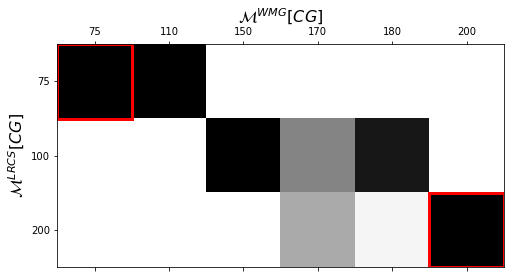

In [30]:
plt.matshow(alphaCG, cmap='Greys')
highlight_cell(0,0,color='red',linewidth=3)
highlight_cell(5,2,color='red',linewidth=3)

plt.xlabel('$\mathcal{M}^{WMG}[CG]$',fontsize=16,position='top')
plt.xticks(ticks=range(len(dom_CG_WMG)),labels=dom_CG_WMG)
plt.ylabel('$\mathcal{M}^{LRCS}[CG]$',fontsize=16)
plt.yticks(ticks=range(len(dom_CG_LRCS)),labels=dom_CG_LRCS)

([<matplotlib.axis.YTick at 0x1587c7490>,
 [Text(0, 0, '75'), Text(0, 1, '100'), Text(0, 2, '200')])

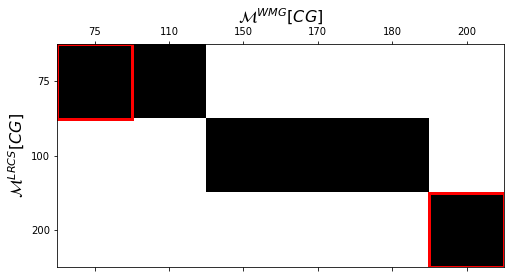

In [31]:
plt.matshow(np.round(alphaCG), cmap='Greys')
highlight_cell(0,0,color='red',linewidth=3)
highlight_cell(5,2,color='red',linewidth=3)

plt.xlabel('$\mathcal{M}^{WMG}[CG]$',fontsize=16,position='top')
plt.xticks(ticks=range(len(dom_CG_WMG)),labels=dom_CG_WMG)
plt.ylabel('$\mathcal{M}^{LRCS}[CG]$',fontsize=16)
plt.yticks(ticks=range(len(dom_CG_LRCS)),labels=dom_CG_LRCS)

([<matplotlib.axis.YTick at 0x1623c8e20>,
 [Text(0, 0, '0'),
  Text(0, 1, '1'),
  Text(0, 2, '2'),
  Text(0, 3, '3'),
  Text(0, 4, '4')])

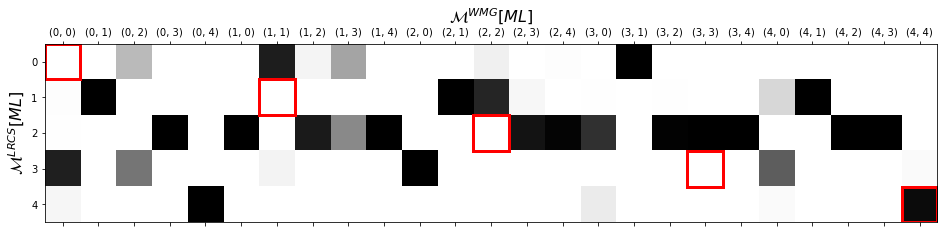

In [32]:
plt.matshow(alphaML, cmap='Greys')
highlight_cell(0,0,color='red',linewidth=3)
highlight_cell(6,1,color='red',linewidth=3)
highlight_cell(12,2,color='red',linewidth=3)
highlight_cell(18,3,color='red',linewidth=3)
highlight_cell(24,4,color='red',linewidth=3)

plt.xlabel('$\mathcal{M}^{WMG}[ML]$',fontsize=16,position='top')
plt.xticks(ticks=range(len(ML_WMG_pltlabels)),labels=ML_WMG_pltlabels)
plt.ylabel('$\mathcal{M}^{LRCS}[ML]$',fontsize=16)
plt.yticks(ticks=range(len(dom_ML_LRCS)),labels=dom_ML_LRCS)

([<matplotlib.axis.YTick at 0x161e9f940>,
 [Text(0, 0, '0'),
  Text(0, 1, '1'),
  Text(0, 2, '2'),
  Text(0, 3, '3'),
  Text(0, 4, '4')])

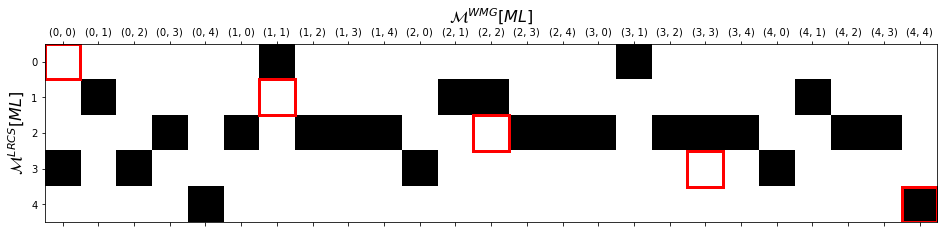

In [33]:
plt.matshow(np.round(alphaML), cmap='Greys')
highlight_cell(0,0,color='red',linewidth=3)
highlight_cell(6,1,color='red',linewidth=3)
highlight_cell(12,2,color='red',linewidth=3)
highlight_cell(18,3,color='red',linewidth=3)
highlight_cell(24,4,color='red',linewidth=3)

plt.xlabel('$\mathcal{M}^{WMG}[ML]$',fontsize=16,position='top')
plt.xticks(ticks=range(len(ML_WMG_pltlabels)),labels=ML_WMG_pltlabels)
plt.ylabel('$\mathcal{M}^{LRCS}[ML]$',fontsize=16)
plt.yticks(ticks=range(len(dom_ML_LRCS)),labels=dom_ML_LRCS)

# Transporting the data

In [34]:
df_LRCS

,Comma gap (µm),Mass Loading (mg cm-2),binned ML
8,200,27.361725,4
9,200,29.772450,4
10,200,27.290821,4
11,200,27.858051,4
12,200,26.936303,4
...,...,...,...
507,200,26.461618,4
508,200,26.967853,4
509,200,27.184811,4
510,200,26.606257,4


In [35]:
data_alphaWMG = {
    'Comma gap (µm)': [],
    'Mass Loading (mg cm-2) ': [],
    'binned ML': []
}

for idx,dfrow in df_WMG.iterrows():
    c = alphaCG[:,dom_CG_WMG.index(dfrow['CG'])]
    r = np.argmax(c)
    new_cg_value = dom_CG_LRCS[r]
    
    positions = []
    for n in range(n_averaging_locations):
        positions.append(list(dom_ML_WMG).index(dfrow['binned ML_avg'+str(n)]))
    powers = (np.ones(n_averaging_locations) * n_bins) ** np.arange(n_averaging_locations)
    ml_index = np.sum(positions*powers)
    c = alphaML[:,int(ml_index)]
    r = np.argmax(c)
    new_ml_value = dom_ML_LRCS[r]
    
    data_alphaWMG['Comma gap (µm)'].append(new_cg_value)
    data_alphaWMG['Mass Loading (mg cm-2) '].append(new_ml_value)
    data_alphaWMG['binned ML'].append(new_ml_value)

In [36]:
df_alphaWMG = pd.DataFrame(data=data_alphaWMG)
df_LRCSWMG = pd.concat([df_LRCS,df_alphaWMG])

In [37]:
df_LRCSWMG

,Comma gap (µm),Mass Loading (mg cm-2),binned ML
8,200,27.361725,4
9,200,29.772450,4
10,200,27.290821,4
11,200,27.858051,4
12,200,26.936303,4
...,...,...,...
234,200,4.000000,4
235,200,4.000000,4
236,200,4.000000,4
237,200,4.000000,4


# Persistence

We store all the objects we have produced.

In [38]:
dt = datetime.datetime.now()
suffix = '{0}{1}{2}_{3}{4}{5}_{6}'.format(dt.year,dt.month,dt.day,dt.hour,dt.minute,dt.second,np.random.randint(10**5))

In [39]:
joblib.dump(df_LRCSWMG,'data/batteries/dfs/df_LRCSWMG_'+suffix+'.pkl')
joblib.dump(loss_jsd,'results/batteries/lossesjsd_'+suffix+'.pkl')
joblib.dump(loss_pen,'results/batteries/lossespen_'+suffix+'.pkl')
joblib.dump(nns,'results/batteries/nns_'+suffix+'.pkl')
joblib.dump(configs,'results/batteries/configs_'+suffix+'.pkl')

['results/batteries/configs_20221026_21457_17512.pkl']